In [27]:
# Set up libraries
import numpy as np
import pdb as pdb
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import time
import laspy
import rioxarray as rxr
import pandas as pd
import math
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, davies_bouldin_score, mean_squared_error
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy import stats

In [2]:
# Set up color tables
x = np.linspace(0.0, 1.0, 256)
rainbow_rgb = plt.get_cmap("rainbow")(x)[np.newaxis, :, :3]

In [28]:
# Define up constants
air_index_of_refraction = 1.0003
c = 2.99792458e8   
number_of_waveform_files = 100000

In [29]:
# Open AOP Pulsewaves file 
# Switch between windows and mac; also between files for clustering/linear regression
# aop_data_dir = 'C:\\Users\\felixyu\\Documents\\GitHub\\Neon-Pls-Wvs-Analysis\\data\\'
# aop_data_dir = '/Users/felixyu/Documents/Remote-Sensing/Neon-Pls-Wvs-Las/data/'
# waveform_file = aop_data_dir + 'lidar.pls'
aop_data_dir = '/Users/felixyu/Documents/Remote-Sensing/Neon-Pls-Wvs-Las/data/'
waveform_file = aop_data_dir + 'NEON_D01_HARV_DP1_L022-1_2019082013_1.pls'
# waveform_file = aop_data_dir + 'NEON_D01_HARV_DP1_L019-1_2019082013_1.pls'
# waveform_file = aop_data_dir + 'NEON_D01_HARV_DP1_L018-1_2019082013_1.pls'
# waveform_file = aop_data_dir + 'NEON_D01_HARV_DP1_L008-1_2019081112.plz'
# point_cloud_file_las = '/Users/felixyu/Documents/Remote-Sensing/Neon-Pls-Wvs-Las/data/NEON_D01_HARV_DP1_L006-1_2017081715_unclassified_point_cloud.las'
# point_cloud_file_laz = '/Users/felixyu/Documents/Remote-Sensing/Neon-Pls-Wvs-Las/data/NEON_D01_HARV_DP1_L006-1_2017081715_unclassified_point_cloud.laz'

In [30]:
# Define a function to detect peaks in the waveform
def waveform_peak_detection(waveform,waveform_intensity_threshold):
    # Define x grid
    x_grid = np.arange(0.0,len(waveform),1.0)

    # Calculate 1st and 2nd derivatives
    deriv_1st = np.gradient(waveform,axis=0,edge_order=1)
    deriv_2nd = np.gradient(deriv_1st,axis=0,edge_order=1)

    #Find locations where 1st derivative crosses 0: (deriv_1st[i] * deriv_1st[i-1] = negative value)
    mult_shift_deriv_1st = deriv_1st * np.roll(deriv_1st,1)
    zero_slope_aoi = np.argwhere(mult_shift_deriv_1st <= 0.0)
    zero_slope_aoi = zero_slope_aoi[:,0]
    zero_slope_count = len(zero_slope_aoi)
    if zero_slope_count > 0:
        zero_slope_aoi = np.reshape(zero_slope_aoi,len(zero_slope_aoi))

    if zero_slope_count == 0:
        return_location_count = 0
        return_peak_location_list = -9999
        return_location_list_x = -9999
        return_intensity_list = -9999    
    else:
        if zero_slope_count == 1:    
            if zero_slope_aoi == 0:
                return_location_count = 0
                return_peak_location_list = -9999
                return_location_list_x = -9999
                return_intensity_list = -9999
            else:
                if deriv_2nd[zero_slope_aoi] < 0.0:
                    return_location_count = 1
                    return_peak_location_list = zero_slope_aoi
                    return_location_list_x = x_grid[zero_slope_aoi]
                    return_intensity_list = waveform[zero_slope_aoi]               
                else:
                    return_location_count = 0
                    return_peak_location_list = -9999
                    return_location_list_x = -9999
                    return_intensity_list = -9999    
        else:
                #Remove bin 0 if included in list
            if zero_slope_aoi[0] == 0:
                zero_slope_aoi = zero_slope_aoi[1:zero_slope_count]
                zero_slope_count = zero_slope_count - 1        
                #Remove sequential bins if included in list and keep first                
            zero_slope_aoi_diff = zero_slope_aoi - np.roll(zero_slope_aoi,1)
            good_zero_slope_aoi = np.argwhere(zero_slope_aoi_diff != 1)
            good_zero_slope_aoi = np.reshape(good_zero_slope_aoi,len(good_zero_slope_aoi))
            zero_slope_aoi = zero_slope_aoi[good_zero_slope_aoi]
            zero_slope_count = len(good_zero_slope_aoi)
            zero_slope_aoi_diff = 0
            good_zero_slope_aoi = 0       
                #Return peaks will have a negative 2nd derivative
            peak_locations_aoi = np.argwhere(deriv_2nd[zero_slope_aoi] < 0.0)
            return_location_count = len(peak_locations_aoi)
            if return_location_count > 0:
                peak_locations_aoi = peak_locations_aoi[:,0]
                peak_locations_aoi = np.reshape(peak_locations_aoi,len(peak_locations_aoi))
                return_peak_location_list = zero_slope_aoi[peak_locations_aoi]
                return_location_list_x = x_grid[zero_slope_aoi[peak_locations_aoi]]
                return_intensity_list = waveform[return_peak_location_list]
            else:
                return_peak_location_list = -9999
                return_location_list_x = -9999
                return_intensity_list = -9999
            peak_locations_aoi = 0

    if return_location_count > 0:
        return_peak_location_list = np.reshape(return_peak_location_list,return_location_count)
        return_location_list_x = np.reshape(return_location_list_x,return_location_count)
        return_intensity_list = np.reshape(return_intensity_list,return_location_count)
                     
        #Remove peaks with peak location at first 2 bins
    if return_location_count > 0:
        good_return_aoi = np.argwhere(return_peak_location_list > 1)
        good_return_count = len(good_return_aoi)
        if good_return_count > 0:
            good_return_aoi = np.reshape(good_return_aoi,good_return_count)
            return_location_count = good_return_count
            return_peak_location_list = return_peak_location_list[good_return_aoi]
            return_location_list_x = return_location_list_x[good_return_aoi]
            return_intensity_list = return_intensity_list[good_return_aoi]
        else:
            return_location_count = 0
            return_peak_location_list = -9999
            return_location_list_x = -9999
            return_intensity_list = -9999        
        good_return_aoi = 0                    

        #Check intensity values for valid peaks
    if return_location_count > 0:
        good_return_aoi = np.argwhere(return_intensity_list >= waveform_intensity_threshold)
        good_return_count = len(good_return_aoi)
        if good_return_count > 0:
            good_return_aoi = np.reshape(good_return_aoi,good_return_count)
            return_location_count = good_return_count
            return_peak_location_list = return_peak_location_list[good_return_aoi]
            return_location_list_x = return_location_list_x[good_return_aoi]
            return_intensity_list = return_intensity_list[good_return_aoi]
        else:
            return_location_count = 0
            return_peak_location_list = -9999
            return_location_list_x = -9999
            return_intensity_list = -9999        
        good_return_aoi = 0    
    
    x_grid = 0
    deriv_1st = 0
    deriv_2nd = 0
    mult_shift_deriv_1st = 0
    zero_slope_aoi = 0
    waveform = 0
    return return_location_count, return_peak_location_list, return_location_list_x, return_intensity_list

In [31]:
def read_NEONAOP_pulsewaves_pulse_information(pls_file, number_of_waveform_files=number_of_waveform_files):
    """
    Reads PulseWaves (PLS) file metadata and pulse information, returning
    instrument name, number of pulses, anchor positions, wave offsets, etc.
    """

    readbin_pls_file = open(pls_file, "rb")
    readbin_pls_file.seek(0, 0)

    # 1. Read PulseWaves Header (many single-value fields).
    file_signature = np.fromfile(readbin_pls_file, np.int8, 16)  # 16 bytes
    global_parameters = int(np.fromfile(readbin_pls_file, np.uint32, 1)[0])
    file_source_id = int(np.fromfile(readbin_pls_file, np.uint32, 1)[0])
    project_id_guid_data1 = int(np.fromfile(readbin_pls_file, np.uint32, 1)[0])
    project_id_guid_data2 = int(np.fromfile(readbin_pls_file, np.uint16, 1)[0])
    project_id_guid_data3 = int(np.fromfile(readbin_pls_file, np.uint16, 1)[0])
    project_id_guid_data4 = np.fromfile(readbin_pls_file, np.uint8, 8)  # 8 bytes
    system_identifier = np.fromfile(readbin_pls_file, np.int8, 64)      # 64 bytes
    generating_software = np.fromfile(readbin_pls_file, np.int8, 64)    # 64 bytes
    file_creation_day_of_year = int(np.fromfile(readbin_pls_file, np.uint16, 1)[0])
    file_creation_year = int(np.fromfile(readbin_pls_file, np.uint16, 1)[0])
    version_major = int(np.fromfile(readbin_pls_file, np.uint8, 1)[0])
    version_minor = int(np.fromfile(readbin_pls_file, np.uint8, 1)[0])
    header_size = int(np.fromfile(readbin_pls_file, np.uint16, 1)[0])
    offset_to_pulse_data = int(np.fromfile(readbin_pls_file, np.int64, 1)[0])
    number_of_pulses = int(np.fromfile(readbin_pls_file, np.int64, 1)[0])
    pulse_format = int(np.fromfile(readbin_pls_file, np.uint32, 1)[0])
    pulse_attributes = int(np.fromfile(readbin_pls_file, np.uint32, 1)[0])
    pulse_size = int(np.fromfile(readbin_pls_file, np.uint32, 1)[0])
    pulse_compression = int(np.fromfile(readbin_pls_file, np.uint32, 1)[0])
    reserved = int(np.fromfile(readbin_pls_file, np.int64, 1)[0])
    number_of_variable_length_records = int(np.fromfile(readbin_pls_file, np.uint32, 1)[0])
    number_of_appended_variable_length_records = int(np.fromfile(readbin_pls_file, np.int32, 1)[0])
    T_scale_factor = float(np.fromfile(readbin_pls_file, np.double, 1)[0])
    T_offset = float(np.fromfile(readbin_pls_file, np.double, 1)[0])
    min_T = int(np.fromfile(readbin_pls_file, np.int64, 1)[0])
    max_T = int(np.fromfile(readbin_pls_file, np.int64, 1)[0])
    x_scale_factor = float(np.fromfile(readbin_pls_file, np.double, 1)[0])
    y_scale_factor = float(np.fromfile(readbin_pls_file, np.double, 1)[0])
    z_scale_factor = float(np.fromfile(readbin_pls_file, np.double, 1)[0])
    x_offset = float(np.fromfile(readbin_pls_file, np.double, 1)[0])
    y_offset = float(np.fromfile(readbin_pls_file, np.double, 1)[0])
    z_offset = float(np.fromfile(readbin_pls_file, np.double, 1)[0])
    min_x = float(np.fromfile(readbin_pls_file, np.double, 1)[0])
    max_x = float(np.fromfile(readbin_pls_file, np.double, 1)[0])
    min_y = float(np.fromfile(readbin_pls_file, np.double, 1)[0])
    max_y = float(np.fromfile(readbin_pls_file, np.double, 1)[0])
    min_z = float(np.fromfile(readbin_pls_file, np.double, 1)[0])
    max_z = float(np.fromfile(readbin_pls_file, np.double, 1)[0])

    # 2. Read variable length records
    vlr_user_id = []
    vlr_record_id = []
    vlr_reserved = []
    vlr_record_length_after_header = []
    vlr_description = []
    vlr_data = []

    pulse_descriptor_size = []
    pulse_descriptor_reserved = []
    pulse_descriptor_optical_center_to_anchor_point = []
    pulse_descriptor_number_of_extra_wave_bytes = []
    pulse_descriptor_number_of_samplings = []
    pulse_descriptor_sample_units = []
    pulse_descriptor_compression = []
    pulse_descriptor_scanner_index = []
    pulse_descriptor_description = []

    sampling_record_pulse_descriptor_index_lookup = []
    sampling_record_size = []
    sampling_record_reserved = []
    sampling_record_type = []
    sampling_record_channel = []
    sampling_record_unused = []
    sampling_record_bits_for_duration_from_anchor = []
    sampling_record_scale_for_duration_from_anchor = []
    sampling_record_offset_for_duration_from_anchor = []
    sampling_record_bits_for_number_of_segments = []
    sampling_record_bits_for_number_of_samples = []
    sampling_record_number_of_segments = []
    sampling_record_number_of_samples = []
    sampling_record_bits_per_sample = []
    sampling_record_lookup_table_index = []
    sampling_record_sample_units = []
    sampling_record_compression = []
    sampling_record_description = []

    num_pulse_descriptor_records = 0

    for i in range(number_of_variable_length_records):
        # Read 1 VLR
        vlr_user_id.append(np.fromfile(readbin_pls_file, np.int8, 16))
        this_record_id = int(np.fromfile(readbin_pls_file, np.uint32, 1)[0])
        vlr_record_id.append(this_record_id)

        vlr_reserved.append(int(np.fromfile(readbin_pls_file, np.uint32, 1)[0]))
        this_record_length = int(np.fromfile(readbin_pls_file, np.int64, 1)[0])
        vlr_record_length_after_header.append(this_record_length)

        vlr_description.append(np.fromfile(readbin_pls_file, np.int8, 64))

        if (this_record_id >= 100001 and this_record_id < 100255):
            # Scanner block
            scanner_size = int(np.fromfile(readbin_pls_file, np.uint32, 1)[0])
            scanner_reserved = int(np.fromfile(readbin_pls_file, np.uint32, 1)[0])
            scanner_instrument = np.fromfile(readbin_pls_file, np.int8, 64)
            scanner_serial = np.fromfile(readbin_pls_file, np.int8, 64)
            scanner_wave_length = float(np.fromfile(readbin_pls_file, np.float32, 1)[0])
            scanner_outgoing_pulse_width = float(np.fromfile(readbin_pls_file, np.float32, 1)[0])
            scanner_scan_pattern = int(np.fromfile(readbin_pls_file, np.uint32, 1)[0])
            scanner_number_of_mirror_facets = int(np.fromfile(readbin_pls_file, np.uint32, 1)[0])
            scanner_scan_frequency = float(np.fromfile(readbin_pls_file, np.float32, 1)[0])
            scanner_scan_angle_min = float(np.fromfile(readbin_pls_file, np.float32, 1)[0])
            scanner_scan_angle_max = float(np.fromfile(readbin_pls_file, np.float32, 1)[0])
            scanner_pulse_frequency = float(np.fromfile(readbin_pls_file, np.float32, 1)[0])
            scanner_beam_diameter_at_exit_apertrue = float(np.fromfile(readbin_pls_file, np.float32, 1)[0])
            scanner_beam_divergence = float(np.fromfile(readbin_pls_file, np.float32, 1)[0])
            scanner_minimal_range = float(np.fromfile(readbin_pls_file, np.float32, 1)[0])
            scanner_maximal_range = float(np.fromfile(readbin_pls_file, np.float32, 1)[0])
            scanner_description = np.fromfile(readbin_pls_file, np.int8, 64)
            continue

        elif (this_record_id >= 20001 and this_record_id < 200255):
            # Pulse descriptor
            pulse_descriptor_index = this_record_id - 200000
            pulse_descriptor_size.append(int(np.fromfile(readbin_pls_file, np.uint32, 1)[0]))
            pulse_descriptor_reserved.append(int(np.fromfile(readbin_pls_file, np.uint32, 1)[0]))
            pulse_descriptor_optical_center_to_anchor_point.append(int(np.fromfile(readbin_pls_file, np.int32, 1)[0]))
            pulse_descriptor_number_of_extra_wave_bytes.append(int(np.fromfile(readbin_pls_file, np.uint16, 1)[0]))
            pulse_descriptor_number_of_samplings.append(int(np.fromfile(readbin_pls_file, np.uint16, 1)[0]))
            pulse_descriptor_sample_units.append(float(np.fromfile(readbin_pls_file, np.float32, 1)[0]))
            pulse_descriptor_compression.append(int(np.fromfile(readbin_pls_file, np.uint32, 1)[0]))
            pulse_descriptor_scanner_index.append(int(np.fromfile(readbin_pls_file, np.uint32, 1)[0]))
            pulse_descriptor_description.append(np.fromfile(readbin_pls_file, np.int8, 64))
            num_pulse_descriptor_records += 1

            # Read sampling records
            for j in range(pulse_descriptor_number_of_samplings[-1]):
                sampling_record_pulse_descriptor_index_lookup.append(pulse_descriptor_index)

                sampling_record_size.append(int(np.fromfile(readbin_pls_file, np.uint32, 1)[0]))
                sampling_record_reserved.append(int(np.fromfile(readbin_pls_file, np.uint32, 1)[0]))
                sampling_record_type.append(int(np.fromfile(readbin_pls_file, np.uint8, 1)[0]))
                sampling_record_channel.append(int(np.fromfile(readbin_pls_file, np.uint8, 1)[0]))
                sampling_record_unused.append(int(np.fromfile(readbin_pls_file, np.uint8, 1)[0]))

                sampling_record_bits_for_duration_from_anchor.append(int(np.fromfile(readbin_pls_file, np.uint8, 1)[0]))
                sampling_record_scale_for_duration_from_anchor.append(float(np.fromfile(readbin_pls_file, np.float32, 1)[0]))
                sampling_record_offset_for_duration_from_anchor.append(float(np.fromfile(readbin_pls_file, np.float32, 1)[0]))

                sampling_record_bits_for_number_of_segments.append(int(np.fromfile(readbin_pls_file, np.uint8, 1)[0]))
                sampling_record_bits_for_number_of_samples.append(int(np.fromfile(readbin_pls_file, np.uint8, 1)[0]))

                sampling_record_number_of_segments.append(int(np.fromfile(readbin_pls_file, np.uint16, 1)[0]))
                sampling_record_number_of_samples.append(int(np.fromfile(readbin_pls_file, np.uint32, 1)[0]))
                sampling_record_bits_per_sample.append(int(np.fromfile(readbin_pls_file, np.uint16, 1)[0]))
                sampling_record_lookup_table_index.append(int(np.fromfile(readbin_pls_file, np.uint16, 1)[0]))
                sampling_record_sample_units.append(float(np.fromfile(readbin_pls_file, np.float32, 1)[0]))
                sampling_record_compression.append(int(np.fromfile(readbin_pls_file, np.uint32, 1)[0]))
                sampling_record_description.append(np.fromfile(readbin_pls_file, np.int8, 64))

            continue
        else:
            # General-purpose VLR data
            vlr_data.append(np.fromfile(readbin_pls_file, np.uint8, this_record_length))

    # 3. Convert lists into NumPy arrays (reshape as needed)
    pulse_descriptor_size_array = np.array(pulse_descriptor_size, dtype=np.uint32)
    pulse_descriptor_reserved_array = np.array(pulse_descriptor_reserved, dtype=np.uint32)
    pulse_descriptor_optical_center_to_anchor_point_array = np.array(
        pulse_descriptor_optical_center_to_anchor_point, dtype=np.int32
    )
    pulse_descriptor_number_of_extra_wave_bytes_array = np.array(
        pulse_descriptor_number_of_extra_wave_bytes, dtype=np.uint16
    )
    pulse_descriptor_number_of_samplings_array = np.array(
        pulse_descriptor_number_of_samplings, dtype=np.uint16
    )
    pulse_descriptor_sample_units_array = np.array(pulse_descriptor_sample_units, dtype=np.float32)
    pulse_descriptor_compression_array = np.array(pulse_descriptor_compression, dtype=np.uint32)
    pulse_descriptor_scanner_index_array = np.array(pulse_descriptor_scanner_index, dtype=np.uint32)

    sampling_record_pulse_descriptor_index_lookup_array = np.array(
        sampling_record_pulse_descriptor_index_lookup, dtype=np.int64
    )
    sampling_record_size_array = np.array(sampling_record_size, dtype=np.uint32)
    sampling_record_reserved_array = np.array(sampling_record_reserved, dtype=np.uint32)
    sampling_record_type_array = np.array(sampling_record_type, dtype=np.uint8)
    sampling_record_channel_array = np.array(sampling_record_channel, dtype=np.uint8)
    sampling_record_unused_array = np.array(sampling_record_unused, dtype=np.uint8)
    sampling_record_bits_for_duration_from_anchor_array = np.array(
        sampling_record_bits_for_duration_from_anchor, dtype=np.uint8
    )
    sampling_record_scale_for_duration_from_anchor_array = np.array(
        sampling_record_scale_for_duration_from_anchor, dtype=np.float32
    )
    sampling_record_offset_for_duration_from_anchor_array = np.array(
        sampling_record_offset_for_duration_from_anchor, dtype=np.float32
    )
    sampling_record_bits_for_number_of_segments_array = np.array(
        sampling_record_bits_for_number_of_segments, dtype=np.uint8
    )
    sampling_record_bits_for_number_of_samples_array = np.array(
        sampling_record_bits_for_number_of_samples, dtype=np.uint8
    )
    sampling_record_number_of_segments_array = np.array(
        sampling_record_number_of_segments, dtype=np.uint16
    )
    sampling_record_number_of_samples_array = np.array(
        sampling_record_number_of_samples, dtype=np.uint32
    )
    sampling_record_bits_per_sample_array = np.array(sampling_record_bits_per_sample, dtype=np.uint16)
    sampling_record_lookup_table_index_array = np.array(
        sampling_record_lookup_table_index, dtype=np.uint16
    )
    sampling_record_sample_units_array = np.array(sampling_record_sample_units, dtype=np.float32)
    sampling_record_compression_array = np.array(sampling_record_compression, dtype=np.uint32)

    # 4. Fix instrument name logic (example: Optech => T_offset=0 if needed)
    instrument_name = str(system_identifier, "UTF-8")  # decode from bytes

    # For certain instruments, T_offset = 0
    if instrument_name.startswith("Galaxy"):
        instrument_name = instrument_name[:6]  # "Galaxy"
        T_offset = 0.0
    if instrument_name.startswith("ALTM GEMINI"):
        instrument_name = "Gemini"
        T_offset = 0.0

    # 5. Prepare arrays to hold pulse info
    gps_timestamp_T_array = np.zeros(number_of_pulses, dtype=np.int64)
    offset_to_waves_array = np.zeros(number_of_pulses, dtype=np.int64)
    anchor_X_array = np.zeros(number_of_pulses, dtype=np.int32)
    anchor_Y_array = np.zeros(number_of_pulses, dtype=np.int32)
    anchor_Z_array = np.zeros(number_of_pulses, dtype=np.int32)
    target_X_array = np.zeros(number_of_pulses, dtype=np.int32)
    target_Y_array = np.zeros(number_of_pulses, dtype=np.int32)
    target_Z_array = np.zeros(number_of_pulses, dtype=np.int32)
    first_returning_sample_array = np.zeros(number_of_pulses, dtype=np.int16)
    last_returning_sample_array = np.zeros(number_of_pulses, dtype=np.int16)
    pulse_data_array = np.zeros((number_of_pulses, 2), dtype=np.int8)
    intensity_array = np.zeros(number_of_pulses, dtype=np.int8)
    classification_array = np.zeros(number_of_pulses, dtype=np.int8)

    gps_timestamp_array = np.zeros(number_of_pulses, dtype=np.float64)
    xyz_anchor_array = np.zeros((number_of_pulses, 3), dtype=np.float64)
    xyz_target_array = np.zeros((number_of_pulses, 3), dtype=np.float64)
    pulse_descriptor_index_array = np.zeros(number_of_pulses, dtype=np.float64)

    dxdydz_array = np.zeros((number_of_pulses, 3), dtype=np.float64)
    xyz_first_array = np.zeros((number_of_pulses, 3), dtype=np.float64)
    xyz_last_array = np.zeros((number_of_pulses, 3), dtype=np.float64)

    # 6. Read PLS Pulse Data
    count = 0
    for iPulse in range(number_of_pulses):
        # Compute file offset for this pulse
        pls_file_offset = offset_to_pulse_data + iPulse * pulse_size
        readbin_pls_file.seek(pls_file_offset, 0)

        # Read single pulse record fields (each is 1 value, so index [0])
        gps_timestamp_T_array[iPulse] = np.fromfile(readbin_pls_file, np.int64, 1)[0]
        offset_to_waves_array[iPulse] = np.fromfile(readbin_pls_file, np.int64, 1)[0]
        anchor_X_array[iPulse] = np.fromfile(readbin_pls_file, np.int32, 1)[0]
        anchor_Y_array[iPulse] = np.fromfile(readbin_pls_file, np.int32, 1)[0]
        anchor_Z_array[iPulse] = np.fromfile(readbin_pls_file, np.int32, 1)[0]
        target_X_array[iPulse] = np.fromfile(readbin_pls_file, np.int32, 1)[0]
        target_Y_array[iPulse] = np.fromfile(readbin_pls_file, np.int32, 1)[0]
        target_Z_array[iPulse] = np.fromfile(readbin_pls_file, np.int32, 1)[0]
        first_returning_sample_array[iPulse] = np.fromfile(readbin_pls_file, np.int16, 1)[0]
        last_returning_sample_array[iPulse] = np.fromfile(readbin_pls_file, np.int16, 1)[0]

        # pulse_data_array has 2 int8's
        pulse_data_array[iPulse, :] = np.fromfile(readbin_pls_file, np.int8, 2)

        intensity_array[iPulse] = np.fromfile(readbin_pls_file, np.int8, 1)[0]
        classification_array[iPulse] = np.fromfile(readbin_pls_file, np.int8, 1)[0]

        # Compute scaled values
        gps_timestamp_array[iPulse] = float(gps_timestamp_T_array[iPulse]) * T_scale_factor + T_offset
        xyz_anchor_array[iPulse, 0] = float(anchor_X_array[iPulse]) * x_scale_factor + x_offset
        xyz_anchor_array[iPulse, 1] = float(anchor_Y_array[iPulse]) * y_scale_factor + y_offset
        xyz_anchor_array[iPulse, 2] = float(anchor_Z_array[iPulse]) * z_scale_factor + z_offset

        xyz_target_array[iPulse, 0] = float(target_X_array[iPulse]) * x_scale_factor + x_offset
        xyz_target_array[iPulse, 1] = float(target_Y_array[iPulse]) * y_scale_factor + y_offset
        xyz_target_array[iPulse, 2] = float(target_Z_array[iPulse]) * z_scale_factor + z_offset

        pulse_descriptor_index_array[iPulse] = pulse_data_array[iPulse, 0]

        # Calculate dx, dy, dz
        dxdydz_array[iPulse, 0] = (xyz_target_array[iPulse, 0] - xyz_anchor_array[iPulse, 0]) / 1000.0
        dxdydz_array[iPulse, 1] = (xyz_target_array[iPulse, 1] - xyz_anchor_array[iPulse, 1]) / 1000.0
        dxdydz_array[iPulse, 2] = (xyz_target_array[iPulse, 2] - xyz_anchor_array[iPulse, 2]) / 1000.0

        # Calculate first/last sample positions
        first_return = float(first_returning_sample_array[iPulse])
        last_return = float(last_returning_sample_array[iPulse])

        xyz_first_array[iPulse, 0] = xyz_anchor_array[iPulse, 0] + first_return * dxdydz_array[iPulse, 0]
        xyz_first_array[iPulse, 1] = xyz_anchor_array[iPulse, 1] + first_return * dxdydz_array[iPulse, 1]
        xyz_first_array[iPulse, 2] = xyz_anchor_array[iPulse, 2] + first_return * dxdydz_array[iPulse, 2]

        xyz_last_array[iPulse, 0] = xyz_anchor_array[iPulse, 0] + last_return * dxdydz_array[iPulse, 0]
        xyz_last_array[iPulse, 1] = xyz_anchor_array[iPulse, 1] + last_return * dxdydz_array[iPulse, 1]
        xyz_last_array[iPulse, 2] = xyz_anchor_array[iPulse, 2] + last_return * dxdydz_array[iPulse, 2]

        # Just a safety check for user-supplied limit
        count += 1
        if count > number_of_waveform_files:
            break

    readbin_pls_file.close()

    # 7. Return whatever pieces you need downstream
    return (instrument_name,
            number_of_pulses,
            xyz_anchor_array,
            dxdydz_array,
            xyz_first_array,
            xyz_last_array,
            offset_to_pulse_data,
            pulse_size,
            T_scale_factor,
            T_offset,
            x_scale_factor,
            x_offset,
            y_scale_factor,
            y_offset,
            z_scale_factor,
            z_offset,
            sampling_record_pulse_descriptor_index_lookup_array,
            pulse_descriptor_optical_center_to_anchor_point_array,
            pulse_descriptor_number_of_extra_wave_bytes_array,
            pulse_descriptor_number_of_samplings_array,
            sampling_record_bits_for_duration_from_anchor_array,
            sampling_record_scale_for_duration_from_anchor_array,
            sampling_record_offset_for_duration_from_anchor_array,
            sampling_record_bits_for_number_of_segments_array,
            sampling_record_bits_for_number_of_samples_array,
            sampling_record_number_of_segments_array,
            sampling_record_number_of_samples_array,
            sampling_record_bits_per_sample_array)


In [6]:
# Read waveform information for AOP
# Read pulse ancillary info from waveform file: origin/platform/anchor location, ray dxdydz, first and last bin geolocation
start = time.time()
waveform_files = waveform_file.split('.')
pls_file = waveform_files[0] + '.pls'

instrument_name, number_of_pulses, xyz_origin_array, dxdydz_array, xyz_bin0_array, xyz_lastbin_array, \
offset_to_pulse_data, pulse_size, T_scale_factor, T_offset, x_scale_factor, x_offset, y_scale_factor, y_offset, \
z_scale_factor, z_offset, sampling_record_pulse_descriptor_index_lookup_array, pulse_descriptor_optical_center_to_anchor_point_array, \
pulse_descriptor_number_of_extra_wave_bytes_array, pulse_descriptor_number_of_samplings_array, \
sampling_record_bits_for_duration_from_anchor_array, sampling_record_scale_for_duration_from_anchor_array, \
sampling_record_offset_for_duration_from_anchor_array, sampling_record_bits_for_number_of_segments_array, \
sampling_record_bits_for_number_of_samples_array, sampling_record_number_of_segments_array, \
sampling_record_number_of_samples_array, sampling_record_bits_per_sample_array = read_NEONAOP_pulsewaves_pulse_information(pls_file) 

if (instrument_name == 'Gemini'):
    beam_footprint = 0.8
elif (instrument_name == 'Galaxy'):
    beam_footprint = 0.25
else:
    beam_footprint = 0.0
    print("Beam Footprint not found")

utmEasting_bin0_array = xyz_bin0_array[:,0]
utmNorthing_bin0_array = xyz_bin0_array[:,1]
elevation_bin0_array = xyz_bin0_array[:,2]
utmEasting_lastbin_array = xyz_lastbin_array[:,0]
utmNorthing_lastbin_array = xyz_lastbin_array[:,1]
elevation_lastbin_array = xyz_lastbin_array[:,2]

end = time.time()
print(instrument_name)
print(beam_footprint)
print(number_of_pulses)
print(pulse_size)

# Mask each array with 0.0 to print out accurate easting and northing information
masked_utm_easting_arr = np.ma.masked_equal(utmEasting_bin0_array, 0.0)
masked_utm_northing_arr = np.ma.masked_equal(utmNorthing_bin0_array, 0.0)
print(np.min(masked_utm_easting_arr),np.max(utmEasting_bin0_array))
print(np.min(masked_utm_northing_arr),np.max(utmNorthing_bin0_array))
print(np.min(elevation_bin0_array),np.max(elevation_bin0_array))
print(np.min(utmEasting_lastbin_array),np.max(utmEasting_lastbin_array))
print(np.min(utmNorthing_lastbin_array),np.max(utmNorthing_lastbin_array))
print(np.min(elevation_lastbin_array),np.max(elevation_lastbin_array))
print(f"Total runtime {end - start}s")


Gemini
0.8
28036820
48
726323.2464400003 726881.44436
4695707.69844 4695909.26
0.0 206.63203999999894
0.0 726883.37525
0.0 4695909.494999999
0.0 200.0187500000003
Total runtime 9.020195722579956s


In [7]:
min_intensity1 = 400.0
max_intensity1 = 75.0

waveform_rgb_lut1 = np.int16((waveform_z_abs_firstreturn_array - min_intensity1) / max_intensity1 * 255)
low_aoi = np.argwhere(waveform_rgb_lut1 < 0)
if len(low_aoi) > 0:
    waveform_rgb_lut1[low_aoi] = 0
high_aoi = np.argwhere(waveform_rgb_lut1 > 255)
if len(high_aoi) > 0:
    waveform_rgb_lut1[high_aoi] = 255
    

NameError: name 'waveform_z_abs_firstreturn_array' is not defined

In [38]:
# Define a function to read a pulsewaves waveform for a single pulse
def read_NEONAOP_pulsewaves_waveform(readbin_pls_file,readbin_wvs_file,iPulse,offset_to_pulse_data,pulse_size,T_scale_factor,T_offset,x_scale_factor,x_offset,y_scale_factor,y_offset,z_scale_factor,z_offset,sampling_record_pulse_descriptor_index_lookup_array,pulse_descriptor_optical_center_to_anchor_point_array,pulse_descriptor_number_of_extra_wave_bytes_array,pulse_descriptor_number_of_samplings_array,sampling_record_bits_for_duration_from_anchor_array,sampling_record_scale_for_duration_from_anchor_array,sampling_record_offset_for_duration_from_anchor_array,sampling_record_bits_for_number_of_segments_array,sampling_record_bits_for_number_of_samples_array,sampling_record_number_of_segments_array,sampling_record_number_of_samples_array,sampling_record_bits_per_sample_array):    
    readbin_pls_file.seek(0,0)
    readbin_wvs_file.seek(0,0)
    
    # Read pulse record
    pls_file_offset = int(offset_to_pulse_data + iPulse * pulse_size) 
    readbin_pls_file.seek(pls_file_offset, 0)
    
    gps_timestamp_T = np.fromfile(readbin_pls_file, np.int64, 1)
    gps_timestamp_T = gps_timestamp_T[0]  # Now it's a scalar
    offset_to_waves = np.fromfile(readbin_pls_file, np.int64, 1)
    offset_to_waves = offset_to_waves[0]
    
    anchor_X = np.fromfile(readbin_pls_file, np.int32, 1)[0]
    anchor_Y = np.fromfile(readbin_pls_file, np.int32, 1)[0]
    anchor_Z = np.fromfile(readbin_pls_file, np.int32, 1)[0]
    target_X = np.fromfile(readbin_pls_file, np.int32, 1)[0]
    target_Y = np.fromfile(readbin_pls_file, np.int32, 1)[0]
    target_Z = np.fromfile(readbin_pls_file, np.int32, 1)[0]
    first_returning_sample = np.fromfile(readbin_pls_file, np.int16, 1)[0]
    last_returning_sample  = np.fromfile(readbin_pls_file, np.int16, 1)[0]
    pulse_data = np.fromfile(readbin_pls_file,np.int8,2)  
    intensity = np.fromfile(readbin_pls_file,np.int8,1)
    classification = np.fromfile(readbin_pls_file,np.int8,1)
    
    gps_timestamp = float(gps_timestamp_T) * T_scale_factor + T_offset
    x_anchor     = float(anchor_X) * x_scale_factor + x_offset
    y_anchor     = float(anchor_Y) * y_scale_factor + y_offset
    z_anchor     = float(anchor_Z) * z_scale_factor + z_offset
    x_target     = float(target_X) * x_scale_factor + x_offset
    y_target     = float(target_Y) * y_scale_factor + y_offset
    z_target     = float(target_Z) * z_scale_factor + z_offset      
    pulse_descriptor_index = pulse_data[0]
    dx = (x_target - x_anchor) / 1000.0
    dy = (y_target - y_anchor) / 1000.0
    dz = (z_target - z_anchor) / 1000.0
    x_first = x_anchor + float(first_returning_sample) * dx
    y_first = y_anchor + float(first_returning_sample) * dy
    z_first = z_anchor + float(first_returning_sample) * dz
    x_last = x_anchor + float(last_returning_sample) * dx
    y_last = y_anchor + float(last_returning_sample) * dy
    z_last = z_anchor + float(last_returning_sample) * dz      
    multiple_segments_bool = False
    
    #read waveforms
    pulse_descriptor_aoi = np.argwhere(sampling_record_pulse_descriptor_index_lookup_array == pulse_descriptor_index)
    pulse_descriptor_aoi = np.reshape(pulse_descriptor_aoi,len(pulse_descriptor_aoi))

    optical_center_to_anchor_point = pulse_descriptor_optical_center_to_anchor_point_array[pulse_descriptor_index-1]
    number_of_extra_wave_bytes = pulse_descriptor_number_of_extra_wave_bytes_array[pulse_descriptor_index-1]
    number_of_samplings = pulse_descriptor_number_of_samplings_array[pulse_descriptor_index-1]

    bits_for_duration_from_anchor_array = sampling_record_bits_for_duration_from_anchor_array[pulse_descriptor_aoi]
    scale_for_duration_from_anchor_array = sampling_record_scale_for_duration_from_anchor_array[pulse_descriptor_aoi]
    offset_for_duration_from_anchor_array = sampling_record_offset_for_duration_from_anchor_array[pulse_descriptor_aoi]
    bits_for_number_of_segments_array = sampling_record_bits_for_number_of_segments_array[pulse_descriptor_aoi]
    bits_for_number_of_samples_array = sampling_record_bits_for_number_of_samples_array[pulse_descriptor_aoi]
    number_of_segments_array = sampling_record_number_of_segments_array[pulse_descriptor_aoi]
    number_of_samples_array = sampling_record_number_of_samples_array[pulse_descriptor_aoi]
    bits_per_sample_array = sampling_record_bits_per_sample_array[pulse_descriptor_aoi]    

    wvs_file_offset = offset_to_waves
    readbin_wvs_file.seek(offset_to_waves, 0)

    if(number_of_extra_wave_bytes > 0):
        extra_wave_bytes = np.fromfile(readbin_wvs_file,np.int8,number_of_extra_wave_bytes)
        
    for iSampling in range(number_of_samplings):
        # print(f"Num of samplings: {number_of_samplings}")
        if bits_for_number_of_segments_array[iSampling] != 0:
            number_of_segments_number_of_bits = bits_for_number_of_segments_array[iSampling]
            if number_of_segments_number_of_bits[0] == 8:
                number_of_segments = np.fromfile(readbin_wvs_file,np.uint8,1)
            elif number_of_segments_number_of_bits[0] == 16:
                number_of_segments = np.fromfile(readbin_wvs_file,np.uint16,1)            
            elif number_of_segments_number_of_bits[0] == 32:
                number_of_segments = np.fromfile(readbin_wvs_file,np.uint32,1)
        else:
            number_of_segments = number_of_segments_array[iSampling]    

        waveform_segments_array = np.zeros((500,number_of_segments))
        number_of_samples_array = np.zeros(number_of_segments)
        scaled_duration_from_anchor_for_segment_array = np.zeros(number_of_segments)                    

        for iSegment in range(number_of_segments):
            # print(f"Num of segments: {number_of_segments}")
            duration_from_anchor_number_of_bits = bits_for_duration_from_anchor_array[iSampling]
            if duration_from_anchor_number_of_bits == 8:
                duration_from_anchor = np.fromfile(readbin_wvs_file,np.uint8,1)
            elif duration_from_anchor_number_of_bits == 16:
                duration_from_anchor = np.fromfile(readbin_wvs_file,np.uint16,1)            
            elif duration_from_anchor_number_of_bits == 32:
                duration_from_anchor = np.fromfile(readbin_wvs_file,np.uint32,1)

            if bits_for_number_of_samples_array[iSampling] != 0:
                number_of_samples_number_of_bits = bits_for_number_of_samples_array[iSampling]    
                if number_of_samples_number_of_bits == 8:
                    number_of_samples = np.fromfile(readbin_wvs_file,np.uint8,1)
                elif number_of_samples_number_of_bits == 16:
                    number_of_samples = np.fromfile(readbin_wvs_file,np.uint16,1)            
                elif number_of_samples_number_of_bits == 32:
                    number_of_samples = np.fromfile(readbin_wvs_file,np.uint32,1)
            else:
                number_of_samples = number_of_samples_array[iSampling] 
                        
            if number_of_samples > 0:   
                bits_per_sample_number_of_bits = bits_per_sample_array[iSampling]
                    
            if bits_per_sample_number_of_bits == 8:
                waveform_segment = np.fromfile(readbin_wvs_file,np.uint8,number_of_samples[0])
            elif bits_per_sample_number_of_bits == 16:
                waveform_segment = np.fromfile(readbin_wvs_file,np.uint16,number_of_samples[0])            
            elif bits_per_sample_number_of_bits == 32:
                waveform_segment = np.fromfile(readbin_wvs_file,np.uint32,number_of_samples[0])

            scaled_duration_from_anchor_for_segment = (duration_from_anchor * scale_for_duration_from_anchor_array[iSampling] + offset_for_duration_from_anchor_array[iSampling]).item()

            waveform_segments_array[0:number_of_samples[0],iSegment] = waveform_segment
            number_of_samples_array[iSegment] = number_of_samples[0]
            scaled_duration_from_anchor_for_segment_array[iSegment] = scaled_duration_from_anchor_for_segment
                                                                
            waveform_segment = 0

        number_of_samples_array = np.int16(number_of_samples_array)
        
        if iSampling == 0:
            neon_waveform_outgoing_pulse = waveform_segments_array[0:number_of_samples_array[0]]
        else:
            scaled_duration_from_anchor_for_segment0 = scaled_duration_from_anchor_for_segment_array[0]
            good_segments_aoi = np.argwhere(scaled_duration_from_anchor_for_segment_array > 0)
            good_segments_aoi = np.reshape(good_segments_aoi,len(good_segments_aoi))
            number_of_good_segments = len(good_segments_aoi)
            if number_of_good_segments > 1:
                multiple_segments_bool = True
                # print("Multiple segments")
                # Combine multiple segments
                neon_waveform_return_pulse = np.zeros(np.int16(scaled_duration_from_anchor_for_segment_array[np.max(good_segments_aoi)] - scaled_duration_from_anchor_for_segment_array[0] + number_of_samples_array[np.max(good_segments_aoi)]))
                for iSegment in range(number_of_good_segments):
                    array_start_pos = np.int16(scaled_duration_from_anchor_for_segment_array[good_segments_aoi[iSegment]] - scaled_duration_from_anchor_for_segment_array[0])
                    neon_waveform_return_pulse[array_start_pos:array_start_pos+number_of_samples_array[good_segments_aoi[iSegment]]] = waveform_segments_array[0:number_of_samples_array[good_segments_aoi[iSegment]],good_segments_aoi[iSegment]]                                                     
            else:
                # Bug fix: Removed the -1 from number of samples array to include entire segment
                neon_waveform_return_pulse = waveform_segments_array[0:number_of_samples_array[0],0]
                # print(neon_waveform_return_pulse)
            
        waveform_segments_array = 0
        number_of_samples_array = 0
        scaled_duration_from_anchor_for_segment_array = 0 
        # print(f"Z_first: {z_first}")
        # print(f"Z_last: {z_last}")
        # print(f"X_first: {x_first}")
        # print(f"X_last: {x_last}")
        # print(f"Y_first: {y_first}")
        # print(f"Y_last: {y_last}")

    # Determine peak location of the outgoing pulse
    outgoing_peak_pos = np.argwhere(neon_waveform_outgoing_pulse == np.max(neon_waveform_outgoing_pulse))
    if len(outgoing_peak_pos) == 1:
        neon_waveform_outgoing_pulse_peak_location = outgoing_peak_pos[0,0]  
    else:
        neon_waveform_outgoing_pulse_peak_location = np.mean(outgoing_peak_pos[:,0])

    # TODO: Check this math
    # Adjust the duration from anchor from bin0 to the peak location of the outgoing pulse
    scaled_duration_from_anchor_for_segment0_adj = scaled_duration_from_anchor_for_segment0 - neon_waveform_outgoing_pulse_peak_location
            
    # Fill in multiple segment gaps with the minimum valid return waveform value, then subtract the min
    return_good_aoi = np.argwhere(neon_waveform_return_pulse > 0)
    return_good_aoi = np.reshape(return_good_aoi,len(return_good_aoi))       
    return_bad_aoi = np.argwhere(neon_waveform_return_pulse == 0)
    return_bad_aoi = np.reshape(return_bad_aoi,len(return_bad_aoi))                          
    if len(return_bad_aoi) > 0:
        neon_waveform_return_pulse[return_bad_aoi] = np.min(neon_waveform_return_pulse[return_good_aoi])
    neon_waveform_offset = np.min(neon_waveform_return_pulse[return_good_aoi])
    neon_waveform_return_pulse = neon_waveform_return_pulse - neon_waveform_offset
        
    # Calculate absolute x,y,z axes for pulse
    # neon_waveform_x_axis = (np.arange(len(neon_waveform_return_pulse)) + scaled_duration_from_anchor_for_segment0_adj) * dx + x_anchor
    # neon_waveform_y_axis = (np.arange(len(neon_waveform_return_pulse)) + scaled_duration_from_anchor_for_segment0_adj) * dy + y_anchor
    # neon_waveform_z_axis = (np.arange(len(neon_waveform_return_pulse)) + scaled_duration_from_anchor_for_segment0_adj) * dz + z_anchor

    # From pulsewaves: d = scale_for_duration_from_anchor * D + offset_for_duration_from_anchor
    # Duration from anchor is how long it takes energy from sensor to anchor + returning to sensor
    # This edit makes z-last accurate and appear, but the peak is now lower
    # Makes the anchor point the start of the segment instead of the peak
    neon_waveform_x_axis = (np.arange(len(neon_waveform_return_pulse)) + scaled_duration_from_anchor_for_segment0) * dx + x_anchor
    # print(neon_waveform_x_axis)
    neon_waveform_y_axis = (np.arange(len(neon_waveform_return_pulse)) + scaled_duration_from_anchor_for_segment0) * dy + y_anchor
    # print(neon_waveform_y_axis)
    neon_waveform_z_axis = (np.arange(len(neon_waveform_return_pulse)) + scaled_duration_from_anchor_for_segment0) * dz + z_anchor
    
    # Return neon_waveform_return_pulse, neon_waveform_x_axis, neon_waveform_y_axis, neon_waveform_z_axis
    # print(f"Intensity: {intensity}")
    # print("Outgoing vs returning")
    # print(neon_waveform_outgoing_pulse)
    # print(neon_waveform_return_pulse)
    return neon_waveform_return_pulse, neon_waveform_x_axis, neon_waveform_y_axis, neon_waveform_z_axis, neon_waveform_offset, multiple_segments_bool
        

In [39]:
def print_waveform_location_information(waveform_x_axis, waveform_y_axis, waveform_z_axis, return_peak_locations):
    ground_return_index = np.argmin(waveform_z_axis)
    max_return_index = np.argmax(waveform_z_axis)
    
    ground_easting_coord = waveform_x_axis[ground_return_index]
    ground_northing_coord = waveform_y_axis[ground_return_index]
    max_easting_coord = waveform_x_axis[max_return_index]
    max_northing_coord = waveform_y_axis[max_return_index]
    peak_easting_coord = waveform_x_axis[return_peak_locations]
    peak_northing_coord = waveform_y_axis[return_peak_locations]

    min_easting_coord = min(waveform_x_axis)
    max_easting_coord = max(waveform_x_axis)
    min_northing_coord = min(waveform_y_axis)
    max_northing_coord = max(waveform_y_axis)
    
    print(f"Ground return Easting {ground_easting_coord}, Northing: {ground_northing_coord}")
    print(f"Max height return Easting {max_easting_coord}, Northing: {max_northing_coord}")
    print(f"Peak location easting: {peak_easting_coord}, northing: {peak_northing_coord}")
    print(f"Min easting value: {min_easting_coord}, Max easting value: {max_easting_coord}")
    print(f"Min northing value: {min_northing_coord}, Max northing value: {max_northing_coord}")
    return

In [ ]:
# Plot a few waveforms
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8))

waveform_files = waveform_file.split('.')
print(waveform_files)
pls_file = waveform_files[0] + '.pls'
wvs_file = waveform_files[0] + '.wvs'
readbin_pls_file = open(pls_file,"rb")
readbin_pls_file.seek(0,0)
readbin_wvs_file = open(wvs_file,"rb")
readbin_wvs_file.seek(0,0)    

iPulse = 3595429

# dxdydz = dxdydz_array[iPulse,:]
# xyz_bin0 = xyz_bin0_array[iPulse,:]
# xyz_lastbin = xyz_lastbin_array[iPulse,:]
    
# Read waveform
waveform, waveform_x_axis, waveform_y_axis, waveform_z_axis, offset, multiple_segments = read_NEONAOP_pulsewaves_waveform(readbin_pls_file,readbin_wvs_file,iPulse,offset_to_pulse_data,pulse_size,T_scale_factor,T_offset,x_scale_factor,x_offset,y_scale_factor,y_offset,z_scale_factor,z_offset,sampling_record_pulse_descriptor_index_lookup_array,pulse_descriptor_optical_center_to_anchor_point_array,pulse_descriptor_number_of_extra_wave_bytes_array,pulse_descriptor_number_of_samplings_array,sampling_record_bits_for_duration_from_anchor_array,sampling_record_scale_for_duration_from_anchor_array,sampling_record_offset_for_duration_from_anchor_array,sampling_record_bits_for_number_of_segments_array,sampling_record_bits_for_number_of_samples_array,sampling_record_number_of_segments_array,sampling_record_number_of_samples_array,sampling_record_bits_per_sample_array)
# print(waveform_z_axis)
print(np.mean(waveform_x_axis))
print(np.mean(waveform_y_axis))
# Evaluate waveform
#32.0
waveform_intensity_threshold = 10.0

# Peak location indices
# return_location_count, return_peak_location_list, return_location_list_x, return_intensity_list = waveform_peak_detection(waveform,waveform_intensity_threshold)

print_waveform_location_information(waveform_x_axis, waveform_y_axis, waveform_z_axis, [])
ax1.tick_params(axis='both',which='major',labelsize=12)
ax1.set_title('Waveform with No Processing', size = 16)
ax1.set_xlabel('Relative Signal Level [DN]', size = 14)
ax1.set_ylabel('Elevation [m]', size = 14)

mapping_tagging_table = "/Users/felixyu/Documents/Remote-Sensing/Field-Data/Field-Data-CSV/HARV-08-2019/vst_mappingandtagging_harv_2019_08.csv"
apparent_individual_table = "/Users/felixyu/Documents/Remote-Sensing/Field-Data/Field-Data-CSV/HARV-08-2019/vst_apparentindividual_2019_08.csv"
# calculate_total_tree_biomass(4701150.0765750045, 727060.3004000003, 1.5, mapping_tagging_table, apparent_individual_table)
# calculate_total_tree_biomass(4701144.7220450025, 727053.5469, 1.5, mapping_tagging_table, apparent_individual_table)
# calculate_total_tree_biomass(4701159.537899999, 727059.6387400003, 1.5, mapping_tagging_table, apparent_individual_table)
# calculate_total_tree_biomass(4704084.735725004, 727096.4257249999, 1.5, mapping_tagging_table, apparent_individual_table)
# calculate_total_tree_biomass(4700910.284260001, 727894.2476600001, 1.5, mapping_tagging_table, apparent_individual_table)

ax1.plot(waveform,waveform_z_axis,color='black',linewidth=3,zorder=1)
normalize_cumulative_return_energy(waveform, waveform_z_axis, True)
# ax1.scatter(return_intensity_list,waveform_z_axis[return_peak_location_list],color='red',s=80,zorder=2)

readbin_pls_file.close()
readbin_wvs_file.close()

In [53]:
def normalize_cumulative_return_energy(waveform_intensity_x, waveform_elevation_y, plot):
    # Create normalized cumulative signal energy from waveform intensity values
    cumulative_energy_RH_boundaries = [0.25, 0.5, 0.75, 1.0]
    
    # Turn elevation into relative height
    min_elevation = np.min(waveform_elevation_y)
    relative_elevations = waveform_elevation_y - min_elevation

    # Sort intensity by elevation
    combined_data = np.array(list(zip(relative_elevations, waveform_intensity_x)))
    sorted_data = combined_data[combined_data[:, 0].argsort()] 
    
    # Extract sorted intensity and elevation
    sorted_elevation = sorted_data[:, 0]
    sorted_intensity = sorted_data[:, 1]

    # Plot cumulative intensity
    cumulative_intensity_sum = np.cumsum(sorted_intensity)
    normalized_cumulative_intensity = cumulative_intensity_sum / cumulative_intensity_sum[-1]

    if plot:
        plt.figure(figsize=(8, 6))
        plt.plot(normalized_cumulative_intensity, sorted_elevation, label="Normalized Cumulative Signal Level")
        RH_25_index = np.where(normalized_cumulative_intensity == cumulative_energy_RH_boundaries[0])
        RH_50_index = np.where(normalized_cumulative_intensity == cumulative_energy_RH_boundaries[1])
        RH_75_index = np.where(normalized_cumulative_intensity == cumulative_energy_RH_boundaries[2])
        RH_100_index = np.where(normalized_cumulative_intensity == cumulative_energy_RH_boundaries[3])
    
        # DN has no processing (raw lidar intensity)
        plt.xlabel("Normalized Cumulative Signal Level (DN)")
        plt.ylabel("Elevation (m)")
        plt.title("Normalized Cumulative Signal Level")
        plt.legend()
        plt.show()
    # print(f"25: {sorted_elevation[RH_25_index]}, 50: {sorted_elevation[RH_50_index]}, 75: {sorted_elevation[RH_75_index]}, 100: {sorted_elevation[RH_100_index]}")
    # Stack along the row to feed into KMeans with [normalized_cumulative_intensity1, sorted_elevation1, normalized_cumulative_intensity2, sorted_elevation1] 
    stacked_intensity_elevation = np.stack((normalized_cumulative_intensity, sorted_elevation), axis=1).ravel()
    return stacked_intensity_elevation

In [54]:
def interpolate_waveform_values(waveform, plot):
    # Input: 1d waveform array [norm_cum_signal_level1, elevation1...]
    # Interpolate values so that there is 20 total cumulative signal level values from 0, 0.025, 0.05 ... 1 
    # Needed because all waveform inputs into k-means must be the same size

    outlier = False
    signal_raw_data = waveform[0::2]
    elevation_raw_data = waveform[1::2]

    # Connect the values together with straight lines (linear interpolate)
    connected_function = interp1d(signal_raw_data, elevation_raw_data, kind='linear', bounds_error=False, fill_value=(elevation_raw_data[0], elevation_raw_data[-1]))

    # Set normalized cumulative signal levels from 0-1 with 0.025 increments
    interpolated_signal_levels = np.linspace(0, 1, 41)
    interpolated_elevation_levels = connected_function(interpolated_signal_levels)

    # Handle 0 explicitly
    interpolated_elevation_levels[0] = 0.0
    if interpolated_elevation_levels[-1] > 150:
        print("Too big of a tree for current classification")
        outlier = True

    if plot:
        plt.plot(signal_raw_data, elevation_raw_data, 'o', label='Original Data')        
        plt.plot(interpolated_signal_levels, interpolated_elevation_levels, '-', label='Interpolated Data')  
        plt.xlabel('Normalized Cumulative Signal Levels')
        plt.ylabel('Relative Elevation')
        plt.title('Interpolation')
        plt.legend()
        plt.grid()
        plt.show()
    
    interpolated_stacked_intensity_elevation = np.stack((interpolated_signal_levels, interpolated_elevation_levels), axis=1).ravel()
    # print(interpolated_stacked_intensity_elevation)
    return interpolated_stacked_intensity_elevation, outlier

In [41]:
def calculate_silhouette_score(kmeans_fitted, X_train, k):
    # Metric to find out best values of K and evaluate the model performance
    silhouette_avg = silhouette_score(X_train, kmeans_fitted.labels_)  
            
    print("K-value", k)
    print("Silhouette Score:", silhouette_avg)

In [42]:
def calculate_cumulative_signal_slopes(interpolated_waveforms, min_signal_level, max_signal_level):
    # Calculate slope of waveforms from min_signal_level to the max_signal_level and returns array with slopes of each waveform
    # Interpolated waveforms is a 1D array with signal, elevation
    waveform_slopes = []
    for waveform in interpolated_waveforms:
        signal_x = waveform[0::2]
        elevation_y = waveform[1::2]

        min_index = np.where(signal_x == min_signal_level)[0][0]
        max_index = np.where(signal_x == max_signal_level)[0][0]

        final_signal_x = signal_x[min_index:max_index+1]
        final_elevation_y = elevation_y[min_index:max_index+1]
        slope, intercept = np.polyfit(final_signal_x, final_elevation_y, 1)
        waveform_slopes.append(slope)
        
    return waveform_slopes

In [43]:
def check_normality(interpolated_waveforms, waveform):
    # See if relative elevation (y) is normally distributed for z-score outlier analysis

    if waveform:
        one_d_waveforms = interpolated_waveforms.flatten()
        elevation = one_d_waveforms[1::2]
        cum_signal_level = one_d_waveforms[0::2]
        
        plt.figure(figsize=(6, 6))
        stats.probplot(elevation, dist="norm", plot=plt)
        plt.title("Q-Q Plot for Relative Elevation")
        plt.show()
    
        plt.figure(figsize=(6, 6))
        stats.probplot(cum_signal_level, dist="norm", plot=plt)
        plt.title("Q-Q Plot for Signal Level")
        plt.show()
    else:
        plt.figure(figsize=(6, 6))
        stats.probplot(interpolated_waveforms, dist="norm", plot=plt)
        plt.title("Q-Q Plot for Waveform Slopes")
        plt.show() 


In [44]:
def perform_normal_waveform_outlier_analysis(waveform_slopes):
    # Calculate Z-score analysis and identify outliers 2 z-scores away
    # Waveforms are population so ddof is 0
    z_score_threshold = 3
    z_scores = stats.zscore(waveform_slopes)
    
    outliers = np.where((z_scores > z_score_threshold) | (z_scores < -z_score_threshold))
    return outliers[0]

In [45]:
def calculate_neighbors_distances(interpolated_waveforms, k):
    # Calculate mean neighbors distance to determine epsilon values for DBSCAN clustering
    
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(interpolated_waveforms)
    distances, indices = neighbors_fit.kneighbors(interpolated_waveforms)

    distances = np.mean(distances[:,1:],axis=1)
    distances = np.sort(distances)
    plt.figure(figsize=(6,6))
    plt.title("Average Distance from a point to k-nearest neighbors")
    # Limit x values - different for every graph
    plt.xlim(14000, 16000)
    plt.plot(distances)

In [46]:
def calculate_dbscan_outlier_detection(interpolated_waveforms, min_pts, episilon):
    # Calculate DBSCAN to prune outliers on waveform data
    # min_pts depends on how many clusters in k-mean clustering/classes total
    dbscan = DBSCAN(eps=episilon, min_samples=min_pts)
    dbscan.fit(interpolated_waveforms)
    labels = dbscan.labels_

    # Outliers occur where the labels are -1
    outliers = np.where(labels == -1)[0]

    waveform_outliers = interpolated_waveforms[outliers]
    waveform_non_outliers = np.delete(interpolated_waveforms, outliers)
    print(waveform_outliers)
    plt.figure(figsize=(8,8))
    for waveform in waveform_non_outliers:
        plt.plot(waveform[0::2], waveform[1::2], c=labels)
    for waveform in waveform_outliers:
        plt.plot(waveform[0::2], waveform[1::2], c="red")
    plt.show()

In [47]:
def train_k_means_cluster_cumulative_returns(interpolated_waveforms_train, k_list, evaluate_elbow):
    # Different version of similar function that returns a trained k_means_cluster object for every k in the k-list
    k_means_classifiers = []
    sse = []
    for k in k_list:
        kmeans = KMeans(n_clusters=k, n_init="auto", random_state=42).fit(interpolated_waveforms_train) 
        k_means_classifiers.append(kmeans)
        sse.append(kmeans.inertia_)

    if evaluate_elbow:
        plt.figure(figsize=(6, 6))
        
        plt.xlabel(r'Number of clusters k')
        plt.ylabel('Log Sum of squared distance')
        plt.plot(k_list, np.log(sse), '-o')
        plt.show()
        
    return k_means_classifiers

In [48]:
def test_k_means_cluster_cumulative_returns(k_means_classifiers, X_test, k_list, plot_raw, evaluate_metrics):
    # K-means cluster waveforms based on trained classifiers and return cluster center waveform values and cluster assignments
    # Each is a 2D array with one dimension being the for each k_list and one for actual values
    cluster_centers = []
    test_cluster_assignments = []
    
    if plot_raw:
        plt.figure(figsize=(8, 6))
        for waveform in X_test:
            # Norm cumulative energy is all even, relative elevation is all odd
            plt.plot(waveform[0::2], waveform[1::2])
            
        plt.xlabel("Normalized Cumulative Signal Level (DN)")
        plt.ylabel("Elevation (m)")
        plt.title("Raw Waveform Values")
        plt.grid()
        plt.show()
        
    for classifier in k_means_classifiers:
        test_cluster_assignments.append(classifier.predict(X_test))
        cluster_centers.append(classifier.cluster_centers_)
        
    if evaluate_metrics:
        for i, k in enumerate(k_list):
            # Calculate silhouette score: 1 is best, 0 means clusters are too close together, -1 means assigned to wrong cluster
            # Better for determining how many clusters are best and clustering at individual points
            silhouette_avg = silhouette_score(X_test, test_cluster_assignments[i])  
    
            # Calculate davies_bouldin_index: lower value indicates better clustering (good separation and compactness)
            # higher value suggests poor clustering (overlapping or poorly defined clusters)
            # Better for overall cluster comparisons
            db_index = davies_bouldin_score(X_test, test_cluster_assignments[i])
            print(f"K: {k} Silhouette Score: {silhouette_avg}, Davies Bouldin Score: {db_index}")
    
    return cluster_centers, test_cluster_assignments

In [49]:
def print_apparent_individual_biomass_information(apparent_individual_table, mapping_tagging_table, resolution, debug):
    # Print coordinates and total amount of apparent individuals in the plot based on plot resolution (1m, 3m, 10m, 25m, 50m, 100m)
    # Based on plot diagram found in NEON vegetation structure: https://data.neonscience.org/api/v0/documents/NEON_vegStructure_userGuide_vE?inline=true
    individual_df = pd.read_csv(apparent_individual_table)
    mapping_df = pd.read_csv(mapping_tagging_table)
    total_data_count = 0
    northing_arr = []
    easting_arr = []
    individual_id_arr = []
    
    for row in individual_df.itertuples(index=True, name="Row"):
        # Subplot resolution is always the 2nd number in subplotID
        subplot_resolution = row.subplotID.split("_")[1]
        stemDiameter = row.stemDiameter
        tagStatus = row.tagStatus
        indiv_id = row.individualID
        
        # Check if subplot meets certain criteria to determine geolocation
        if subplot_resolution.isdigit() and int(subplot_resolution) == resolution and not np.isnan(stemDiameter):
            northing = row.adjNorthing
            easting = row.adjEasting
            indiv_id = row.individualID
            
            northing_arr.append(northing)
            easting_arr.append(easting)
            individual_id_arr.append(indiv_id)
            total_data_count += 1
            if debug:
                print(f"Northing: {northing}, Easting: {easting}, ID: {indiv_id}")
            
        # Otherwise check if individual geolocation information is valid (tree is mapped)
        elif not np.isnan(stemDiameter) and row.individualID in mapping_df["individualID"].values:
            mapping_data = mapping_df.loc[mapping_df["individualID"] == indiv_id]
            northing = mapping_data["adjNorthing"].iloc[0]
            easting = mapping_data["adjEasting"].iloc[0]

            if not np.isnan(northing):
                northing_arr.append(northing)
                easting_arr.append(easting)
                individual_id_arr.append(indiv_id)
                total_data_count +=1
                if debug:
                    print(f"Northing: {northing}, Easting: {easting}, ID: {indiv_id}")
                    print("Mapped")
                
    print(f"Total individual data count: {total_data_count}")
    return np.array(northing_arr), np.array(easting_arr), np.array(individual_id_arr), total_data_count

In [50]:
def calculate_indv_tree_biomass(genus, family, species, dbh):
    # Lookup table for tree biomass based on DBH (cm) and genus, family, and species in Chojnacky paper
    # https://www.fs.usda.gov/nrs/pubs/jrnl/2014/nrs_2014_chojnacky_001.pdf
    # Some b0 and b1 are interpolated based on genus if species does not exist
    b0 = 0
    b1 = 0

    # 45 conifer species
    if genus == "Abies":
        if species == "balsamea" or species == "fraseri" or species == "lasiocarpa":
            # Abies < 0.35 spg
            b0 = -2.3123
            b1 = 2.3482
        else:
            # Abies >= 0.35 spg, intepolation for unknown species
            b0 = -3.1774
            b1 = 2.6426
    elif genus == "Thuja":
        if species == "occidentalis":
            # Cupressaceae < 0.30 spg
            b0 = -1.9615
            b1 = 2.1063
        elif species == "plicata":
            # Cupressaceae 0.3 - 0.39 spg
            b0 = -2.7765
            b1 = 2.4195
        else:
            print("No species B0 and B1 found")
    elif genus == "Calocedrus" or genus == "Sequoiadendron":
        # Cupressaceae 0.3 - 0.39 spg
        b0 = -2.7765
        b1 = 2.4195  
    elif genus == "Chamaecyparis" or genus == "Juniperus":
        # Cupressaceae >= 0.4 spg
        b0 = -2.6327
        b1 = 2.4757
    elif genus == "Larix":
        # Larix
        b0 = -2.3012
        b1 = 2.3853
    elif genus == "Picea":
        if species == "engelmannii" or species == "sitchensis":
            # Picea < 0.35 spg
            b0 = -3.03
            b1 = 2.5567
        else:
            # Picea >= 0.35 spg, interpolation for unkown species
            b0 = -2.1364
            b1 = 2.3233
    elif genus == "Pinus":
        if species == "strobus" or species == "echinata" or species == "elliottii" or species == "palustris" or species == "rigida" or species == "taeda":
            # Pinus >= 0.45 spg
            b0 = -3.0506
            b1 = 2.6465
        else:
            # Pinus < 0.45 spg, interpolation for unknown species
            b0 = -2.6177
            b1 = 2.4638
    elif genus == "Pseudotsuga":
        # Pseudotsuga
        b0 = -2.4623
        b1 = 2.4852
    elif genus == "Tsuga":
        if species == "canadensis":
            # Tsuga < 0.4 spg
            b0 = -2.3480
            b1 = 2.3876
        elif species == "heterophylla" or species == "mertensiana":
            # Tsuga >= 0.4 spg
            b0 = -2.9208
            b1 = 2.5697
        else:
            print("No species B0 and B1 found")
            
    # 70 hardwood species taxa, based on family
    elif family == "Aceraceae":
        if species == "saccharum":
            # Aceraceae >= 0.5 spg
            b0 = -1.8011
            b1 = 2.3852
        else:
            # Aceraceae < 0.5 spg, interpolation
            b0 = -2.0470
            b1 = 2.3852
    elif family == "Betulaceae":
        if genus == "Alnus":
            # Betulaceae < 0.4 spg
            b0 = -2.5932
            b1 = 2.5349
        elif species == "papyrifera" or species == "populifolia":
            # Betulaceae 0.4 - 0.49 spg
            b0 = -2.2271
            b1 = 2.4513
        elif species == "alleghaniensis":
            # Betulaceae 0.5 - 0.59
            b0 = -1.8096
            b1 = 2.3480
        elif species == "lenta" or genus == "Ostrya":
            # Betulaceae >= 0.6 spg
            b0 = -2.2652
            b1 = 2.5349
        else:
            # Specific gravity > 0.6 used for interpolation
            b0 = -2.2652
            b1 = 2.5349
    elif family == "Cornaceae" or family == "Ericaceae" or family == "Lauraceae" or family == "Platanaceae" or family == "Rosaceae" or family == "Ulmaceae":
        b0 = -2.2118
        b1 = 2.4133
    elif family == "Juglandaceae":
        # Fabaceae/Juglandaceae Carya
        b0 = -2.5095
        b1 = 2.6175
    elif family == "Fabaceae":
        # Fabaceae other
        b0 = -2.5095
        b1 = 2.5437
    elif family == "Fagaceae":
        # Evergreen Fagaceae (e.g. Quercus chrysolepis, Q. laurifolia, Lithocarpus, etc.)
        evergreen_oaks = ["chrysolepis","densiflorus","douglasii","laurifolia","minima"]
        if species in evergreen_oaks:
            b0 = -2.2189
            b1 =  2.4410
        else:
            # Deciduous Fagaceae (e.g. Quercus alba, Q. rubra, etc., Castanea, Fagus)
            b0 = -2.0705
            b1 =  2.4410  
    elif family == "Hamamelidaceae":
        b0 = -2.6390
        b1 =  2.5466
    elif family in ["Hippocastanaceae", "Tiliaceae"]:
        b0 = -2.4108
        b1 =  2.1777
    elif family == "Magnoliaceae":
        b0 = -2.5497
        b1 =  2.5011
    elif family == "Oleaceae":
        if species == "americana":
            # Oleaceae >= 0.55 spg
            b0 = -1.8384
            b1 =  2.4950
        else:
            b0 = -2.0314
            b1 = 2.3524
    elif family == "Salicaceae":
        poplar_spg_map = {
            "balsamifera":   0.31,
            "trichocarpa":   0.31,
            "spp":           0.34, 
            "deltoides":     0.37,
            "grandidentata": 0.36,
            "tremuloides":   0.35
        }
        willow_spg_map = {
            "alba": 0.36,
            "spp":  0.36
        }

        if genus == "Populus":
            spg_val = poplar_spg_map.get(species, 0.34)
        elif genus == "Salix":
            spg_val = willow_spg_map.get(species, 0.36)
        else:
            spg_val = 0.36 

        if spg_val < 0.35:
            b0 = -2.6683
            b1 =  2.4561
        else:
            b0 = -2.4441
            b1 =  2.4291      
            
    # 15 Woodland species, uses drc instead of dbh
    elif family == "Cupressaceae":
        # e.g. Cupressus spp, Juniperus monosperma/occidentalis/osteosperma, etc.
        b0 = -2.7096
        b1 =  2.1942
    elif family in ["Fabaceae", "Rosaceae"]:
        # Fabaceae or Rosaceae group
        b0 = -2.9255
        b1 =  2.4109
    elif family == "Fagaceae":
        # Fagaceae group
        b0 = -3.0304
        b1 =  2.4982
    elif family == "Pinaceae":
        # Pinaceae group
        b0 = -3.2007
        b1 =  2.5339

    else:
        # The tree/shrub doesn't match any of the species
        print("Error: The tree/shrub doesn't match any of the species")
    return b0, b1

In [51]:
def calculate_total_tree_biomass(northing_area, easting_area, resolution, mapping_tagging_table, apparent_individual_table):

    biomass_data = []
    individual_df = pd.read_csv(apparent_individual_table)
    mapping_df = pd.read_csv(mapping_tagging_table)

    # Filter all mapping and tagging points to be within the northing area and easting area (bounding box)
    northing_range_max = northing_area + resolution/2
    northing_range_min = northing_area - resolution/2
    easting_range_max = easting_area + resolution/2
    easting_range_min = easting_area - resolution/2

    mapping_df_filtered = mapping_df[(mapping_df["adjNorthing"] >= northing_range_min) & (mapping_df["adjNorthing"] <= northing_range_max) 
                                    & (mapping_df["adjEasting"] >= easting_range_min) & (mapping_df["adjEasting"] <= easting_range_max)]
    
    not_found_count = 0
    lost_na_data_count = 0
    for row in mapping_df_filtered.itertuples(index=True, name="Row"):
        # Search mapping and tagging to get precise geolocation and species for individual table values
        if row.individualID in individual_df["individualID"].values:
            genus = row.genus
            family = row.family
            species = row.scientificName.split(" ")[1]
            # print(genus)
            # print(species)
            # print(family)

            # Get diameter breast height from individual table and check if tree is lost (no data)
            individual_data = individual_df.loc[individual_df["individualID"] == row.individualID]
            dbh = individual_data["stemDiameter"].iloc[0]
            measurement_height = individual_data["measurementHeight"].iloc[0]

            if np.isnan(dbh):
                lost_na_data_count += 1
                print("Tree data lost or invalid")
                continue

            if measurement_height < 130:
                print("DRC instead of DBH due to smaller tree size")
            b0, b1 = calculate_indv_tree_biomass(genus, family, species, dbh)

            # Based on Chojnacky 2013
            biomass_ln = b0 + b1 * np.log(dbh)
            raw_biomass = np.exp(biomass_ln)
            biomass_data.append(raw_biomass)
            # print(b0, b1, dbh)
            # print(raw_biomass)
            # print(dbh)
            
        else:
            not_found_count += 1
            print("Mapping and tagging not found in individual table")
    total_biomass = np.sum(biomass_data)
    return total_biomass

In [20]:
def find_associated_biomass_waveform_pulse_number(biomass_northing_arr, biomass_easting_arr, waveform_x_axis, waveform_y_axis, shot_number, debug):
    # Check if pulse number is in between the 11 groups in slides
    
    # Find the shot/pulse number associated with each biomass point based on northing, easting, and its resolution 
    min_waveform_easting = np.min(waveform_x_axis)
    max_waveform_easting = np.max(waveform_x_axis)
    min_waveform_northing = np.min(waveform_y_axis)
    max_waveform_northing = np.max(waveform_y_axis)
    waveform_easting = np.mean([min_waveform_easting, max_waveform_easting])
    waveform_northing = np.mean([min_waveform_northing, max_waveform_northing])
    waveform_easting_min = waveform_easting - 0.5
    waveform_easting_max = waveform_easting + 0.5
    waveform_northing_min = waveform_northing - 0.5
    waveform_northing_max = waveform_northing + 0.5
    biomass_found = False

    # Stack biomass arrays for easier searching
    paired_biomass = np.column_stack((biomass_northing_arr, biomass_easting_arr))
    
    # Search paired biomass arrays for waveform
    biomass_index = np.where((paired_biomass[:, 0] >= waveform_northing_min) & (paired_biomass[:, 0] <= waveform_northing_max) & 
                             (paired_biomass[:,1] >= waveform_easting_min) & (paired_biomass[:, 1] <= waveform_easting_max))
    if biomass_index[0].size > 0:
        biomass_found = True
        if debug:
            print(f"Waveform biomass found at {paired_biomass[biomass_index[0]]}")
            print(f"Number of biomass values: {biomass_index[0].size}")

    return biomass_found, waveform_easting, waveform_northing

In [21]:
def find_associated_biomass_waveform_group(waveform_x_axis, waveform_y_axis, grouped_biomass, shot_number):
    # Check if waveform is within a biomass group
    biomass_found = False
    group_index = -2
    min_waveform_easting = np.min(waveform_x_axis)
    max_waveform_easting = np.max(waveform_x_axis)
    min_waveform_northing = np.min(waveform_y_axis)
    max_waveform_northing = np.max(waveform_y_axis)

    for index, group in enumerate(grouped_biomass):
        if min_waveform_easting >= group[0] and max_waveform_easting <= group[1] and min_waveform_northing >= group[2] and max_waveform_northing <= group[3]:
            biomass_found = True
            print(f"Waveform {shot_number} found in group {index + 1}")
    return biomass_found, group

In [22]:
def find_biomass_tree_heights(northing, easting, resolution, mapping_tagging_table, apparent_individual_table):
    biomass_data = []
    individual_df = pd.read_csv(apparent_individual_table)
    mapping_df = pd.read_csv(mapping_tagging_table)

    # Filter all mapping and tagging points to be within the northing area and easting area (bounding box)
    northing_range_max = northing + resolution/2
    northing_range_min = northing - resolution/2
    easting_range_max = easting + resolution/2
    easting_range_min = easting - resolution/2

    mapping_df_filtered = mapping_df[(mapping_df["adjNorthing"] >= northing_range_min) & (mapping_df["adjNorthing"] <= northing_range_max) 
                                    & (mapping_df["adjEasting"] >= easting_range_min) & (mapping_df["adjEasting"] <= easting_range_max)]
    
    not_found_count = 0
    lost_na_data_count = 0
    height = -10
    for row in mapping_df_filtered.itertuples(index=True, name="Row"):
        # Search mapping and tagging to get precise geolocation and species for individual table values
        if row.individualID in individual_df["individualID"].values:
            individual_data = individual_df.loc[individual_df["individualID"] == row.individualID]
            height = individual_data["height"].iloc[0]
            
        else:
            not_found_count += 1
            print("Mapping and tagging not found in individual table")
    return height

In [23]:
waveform_biomass_df = pd.read_csv("/Users/felixyu/Documents/Remote-Sensing/Neon-Pls-Wvs-Las/data/biomass_waveform_data_main.csv")
mapping_table = "/Users/felixyu/Documents/Remote-Sensing/Field-Data/Field-Data-CSV/HARV-08-2019/vst_mappingandtagging_harv_2019_08.csv"
individual_table = "/Users/felixyu/Documents/Remote-Sensing/Field-Data/Field-Data-CSV/HARV-08-2019/vst_apparentindividual_2019_08.csv"

pulsenumbers = waveform_biomass_df["Pulsenumber"].to_numpy().flatten()
easting = waveform_biomass_df["Easting"].to_numpy().flatten()
northing = waveform_biomass_df["Northing"].to_numpy().flatten()
heights_arr = []

for i, e_val in enumerate(easting):
    height = find_biomass_tree_heights(northing[i], e_val, 1.5, mapping_table, individual_table)
    heights_arr.append(height)
heights_arr = np.array(heights_arr)

field_heights_df = pd.DataFrame({'Pulsenumber': pulsenumbers, 'FieldCanopyHeights': heights_arr})
field_heights_df.to_csv("NEON_field_canopy_heights.csv")

In [24]:
def add_waveform_data_row_with_biomass(waveform_file_name, interp_waveform, waveform_x_axis, waveform_y_axis, biomass_value, cluster_number, shot_number, biomass_group_number):
    waveform_elevation_data = list(interp_waveform[1::2])
    waveform_intensity_data = interp_waveform[0::2]

    # Have a seperate dataframe for actual waveform elevation data vs the metadata
    elevation_df = pd.DataFrame([waveform_elevation_data], columns=[f"Elevation_{np.round(waveform_intensity_data[i], 3)}" for i in range(len(waveform_elevation_data))])

    waveform_biomass_df = pd.DataFrame({'FileName': [waveform_file_name], 'Pulsenumber': [shot_number], 'Biomass': [biomass_value], 'Easting': [waveform_x_axis], 'Northing': [waveform_y_axis], 'Group': [biomass_group_number], 'Cluster': [cluster_number]})
    waveform_biomass_df = pd.concat([waveform_biomass_df, elevation_df], axis=1)
    return waveform_biomass_df

In [86]:
def split_test_train_cluster_indices(cluster_group_values, number_of_clusters, clusters_with_no_data, clusters_with_less_than_4, split_percentage):
    # Split into train test for linear regression: 75%, 25% based on clusters
    
    train_indices_aggregate = []
    test_indices_aggregate = []
    
    # Build a dictionary of {cluster number: [associated indices in elevation data]}
    cluster_group_indices_train = {i: [] for i in range(number_of_clusters)}
    cluster_group_indices_test = {i: [] for i in range(number_of_clusters)}

    # Loop through each unique cluster
    unique_clusters = np.unique(cluster_group_values)
    for cluster in unique_clusters:
        if cluster in clusters_with_no_data:
            continue
            
        # Get indices for the current cluster group
        cluster_indices = np.where(cluster_group_values == cluster)[0]
        
        if cluster in clusters_with_less_than_4:
            cluster_group_indices_train[cluster].extend(cluster_indices)
            continue
            
        train_idx, test_idx = train_test_split(cluster_indices, test_size=split_percentage, random_state=42)
        
        # Add the indices to the respective lists
        train_indices_aggregate.extend(train_idx)
        test_indices_aggregate.extend(test_idx)
        cluster_group_indices_train[cluster].extend(train_idx)
        cluster_group_indices_test[cluster].extend(test_idx)

    return train_indices_aggregate, test_indices_aggregate, cluster_group_indices_train, cluster_group_indices_test

In [88]:
def perform_regression_main(waveform_biomass_data_file):
    waveform_biomass_data = pd.read_csv(waveform_biomass_data_file)
    field_canopy_heights_df = pd.read_csv("/Users/felixyu/Documents/Remote-Sensing/Neon-Pls-Wvs-Las/data/NEON_field_canopy_heights.csv")
    
    # DF Variables
    waveforms_with_biomass = waveform_biomass_data.iloc[:, 10:]
    waveform_elevation_data = waveforms_with_biomass.to_numpy()

    cluster_group_values = waveform_biomass_data["Cluster"].to_numpy()
    pulsenumbers = waveform_biomass_data["Pulsenumber"].to_numpy()
    biomass_values = np.array(waveform_biomass_data["Biomass"])
    canopy_top_values = waveform_biomass_data["CanopyTop"].to_numpy()
    canopy_bottom_values = waveform_biomass_data["CanopyBottom"].to_numpy()
    surface_elevation_values = waveform_biomass_data["SurfaceElevation"].to_numpy()
    field_canopy_heights = field_canopy_heights_df["FieldCanopyHeights"].to_numpy()

    # Cluster vars
    number_of_clusters = 8
    cluster_group_count = {i: 0 for i in range(number_of_clusters)}
    cluster_regression_scores = {i: 0 for i in range(number_of_clusters)}
    clusters_with_no_data = [4]
    clusters_with_limited_data = []
    split_percentage = 0.25
    
    # Get metrics
    mid_index = waveform_elevation_data.shape[1] // 2
    quarter_index = waveform_elevation_data.shape[1] // 4
    waveform_elevation_RH100 = waveform_elevation_data[:, [-1]]
    waveform_elevation_RH10 = waveform_elevation_data[:, [5]]
    waveform_elevation_RH975_RH100 = waveform_elevation_data[:, [-2, -1]]
    waveform_elevation_RH975 = waveform_elevation_data[:, [-2]]
    waveform_elevation_RH50 = waveform_elevation_data[:, [mid_index]]
    waveform_elevation_RH50_RH975 = waveform_elevation_data[:, [mid_index, -2]]
    waveform_elevation_RH10_RH975 = waveform_elevation_data[:, [5, -2]]
    waveform_elevation_RH25_RH975 = waveform_elevation_data[:, [quarter_index, -2]]

    waveform_RH_start = canopy_bottom_values - surface_elevation_values
    waveform_canopy_RH975_flattened = waveform_elevation_RH975.flatten() + waveform_RH_start
    
    # Filter out waveforms with negative canopy heights and biomass values below 500 with a canopy height bigger than 20
    non_neg_biomass_ch_mask = ((waveform_canopy_RH975_flattened < 20.0) | (biomass_values > 500)) & (waveform_RH_start >= 0)
    waveform_RH_start_filtered = waveform_RH_start[non_neg_biomass_ch_mask]
    waveform_elevation_RH10_filtered = waveform_elevation_RH10[non_neg_biomass_ch_mask, :]
    waveform_elevation_RH975_filtered = waveform_elevation_RH975[non_neg_biomass_ch_mask, :]
    waveform_elevation_RH50_filtered = waveform_elevation_RH50[non_neg_biomass_ch_mask, :]
    cluster_group_values_filtered = cluster_group_values[non_neg_biomass_ch_mask]
    field_canopy_heights_filtered = field_canopy_heights[non_neg_biomass_ch_mask]
    biomass_values_masked = biomass_values[non_neg_biomass_ch_mask]
    
    waveform_RH_start_column = waveform_RH_start_filtered.reshape(-1, 1)
    waveform_canopy_heights_RH975 = waveform_RH_start_column + waveform_elevation_RH975_filtered
    waveform_canopy_heights_RH975_flattened = waveform_canopy_heights_RH975.flatten()
    waveform_canopy_heights_RH10 = waveform_RH_start_column + waveform_elevation_RH10_filtered
    waveform_canopy_heights_RH50 = waveform_RH_start_column + waveform_elevation_RH50_filtered
    waveform_canopy_heights_RH10_RH975 = np.column_stack((waveform_canopy_heights_RH10, waveform_canopy_heights_RH975))
    waveform_canopy_heights_RH50_RH975 = np.column_stack((waveform_canopy_heights_RH50, waveform_canopy_heights_RH975))
    # print(len(waveform_canopy_heights_RH975_flattened))
    # Get total amount of values in each cluster
    for cluster in cluster_group_values_filtered:
        cluster_group_count[cluster] += 1
        
    print(cluster_group_count)
    # {0: 8, 1: 20, 2: 0, 3: 31, 4: 2, 5: 0, 6: 4, 7: 40, 8: 45, 9: 32}
    
    # # elevation_waveform_train = waveform_elevation_RH50_RH975[train_ind_aggr]
    # # elevation_waveform_test = waveform_elevation_RH50_RH975[test_ind_aggr]

    # elevation_waveform_train = waveform_elevation_RH975_RH100[train_ind_aggr]
    # elevation_waveform_test = waveform_elevation_RH975_RH100[test_ind_aggr]
    
    # cluster_train = cluster_group_values[train_ind_aggr]
    # cluster_test = cluster_group_values[test_ind_aggr]
    
    # pulsenumbers_train = pulsenumbers[train_ind_aggr]
    # pulsenumbers_test = pulsenumbers[test_ind_aggr]
    
    # biomass_train = biomass_values[train_ind_aggr]
    # biomass_test = biomass_values[test_ind_aggr]

    # Fit one linear regression model with all waveforms
    general_reg_graph_title = "Waveform RH97.5/Canopy Height Vs. Biomass"
    perform_general_linear_regression(waveform_canopy_heights_RH975, biomass_values_masked, waveform_canopy_heights_RH975, general_reg_graph_title)

    perform_clustered_linear_regression(waveform_canopy_heights_RH975, biomass_values_masked, number_of_clusters, cluster_group_values_filtered, clusters_with_no_data, clusters_with_limited_data, split_percentage)

    perform_exponential_regression(waveform_canopy_heights_RH975_flattened, biomass_values_masked)

{0: 20, 1: 3, 2: 21, 3: 16, 4: 0, 5: 11, 6: 9, 7: 15}
Intercept: -689.2609146648596
Coefficients: [89.71815811]
R^2: 0.42406703431416637
RMSE: 615.1878506715493


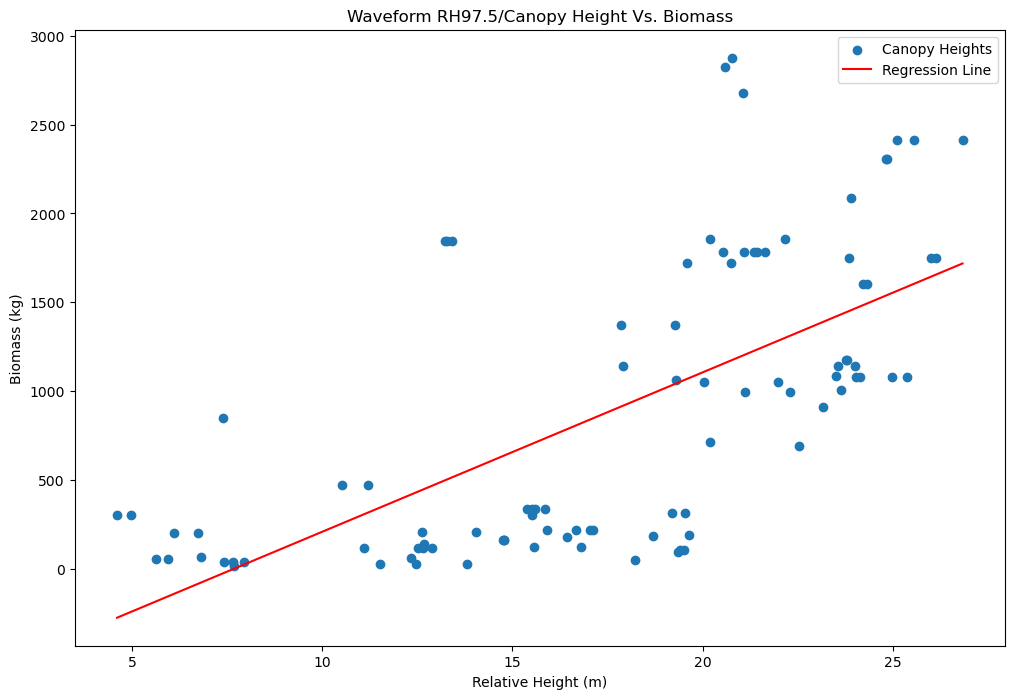

For cluster 0
Intercept: -9468.015272806084
Coefficients: [538.11245706]
Score: 0.2758242761469747


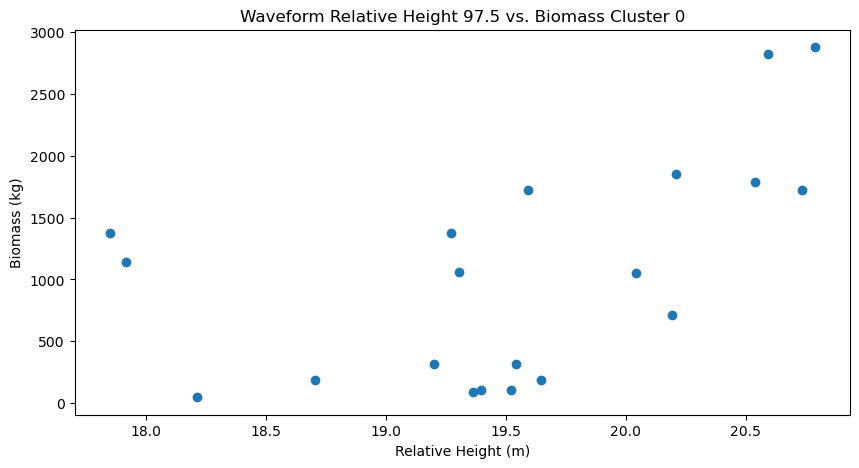

For cluster 1
Intercept: 1521.20076623385
Coefficients: [-256.93756114]
Score: 0.8803923746369894


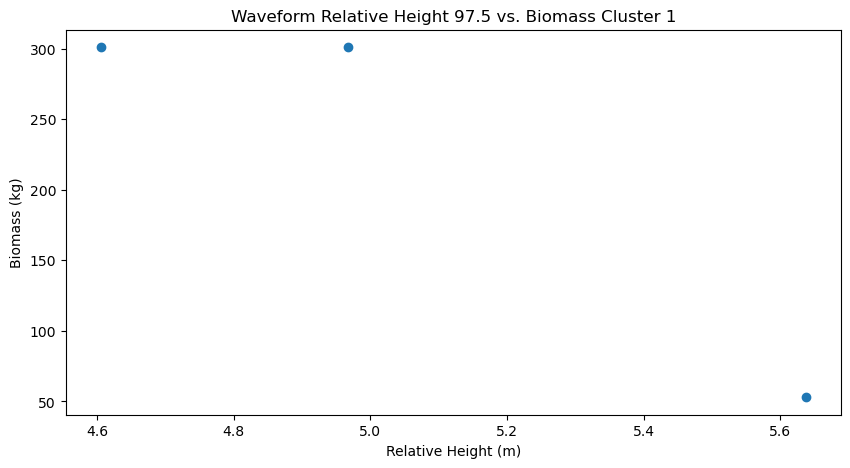

For cluster 2
Intercept: -6325.092894282469
Coefficients: [321.89197713]
Score: 0.3233323011194148


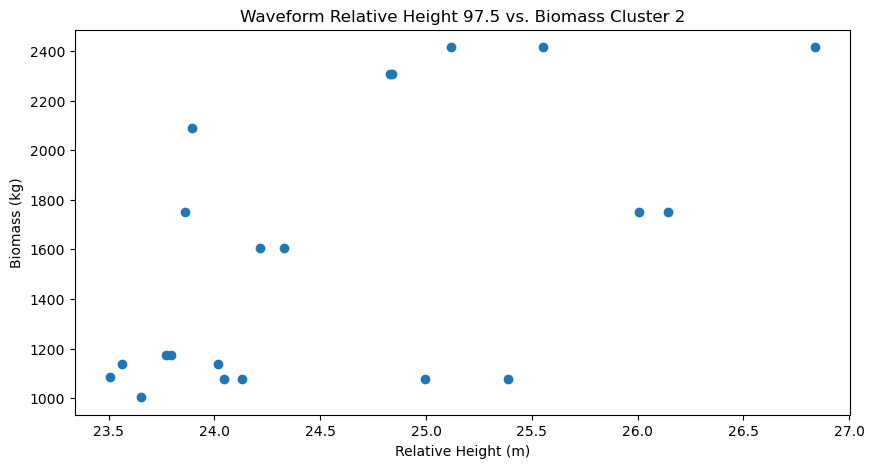

For cluster 3
Intercept: -2133.464184958496
Coefficients: [208.51933595]
Score: 0.0896905724835364


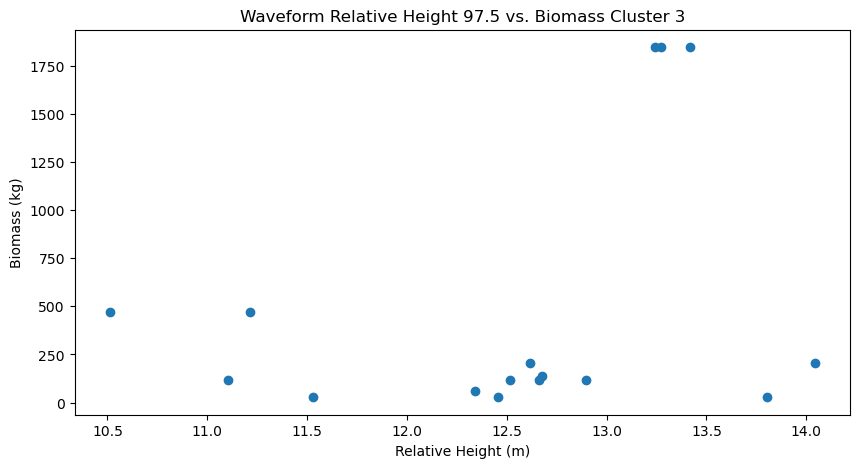

For cluster 5
Intercept: 13488.346097519212
Coefficients: [-550.5821446]
Score: 0.4026308135548067


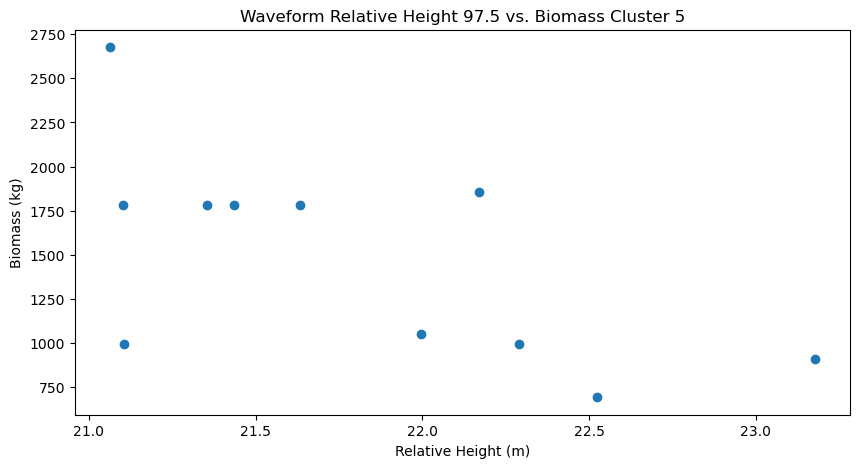

For cluster 6
Intercept: 147.59796518972604
Coefficients: [2.58146905]
Score: 4.870288536862333e-05


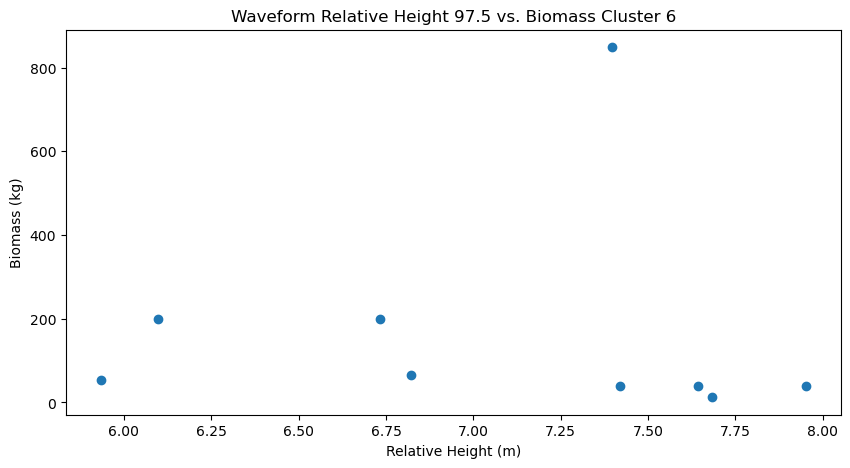

For cluster 7
Intercept: 334.4040747148528
Coefficients: [-6.67024028]
Score: 0.004333338441751211


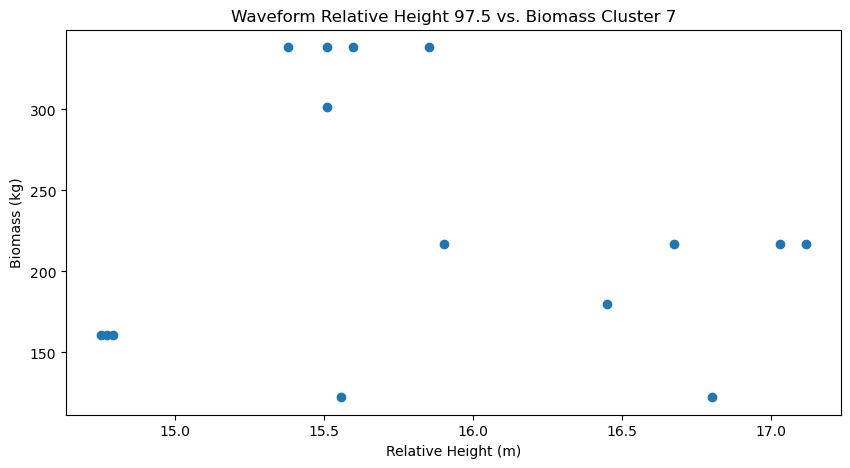

Exponential RMSE: 590.751903937056
A: 142.73216077021956, B: 0.10438035553048318, C: -167.4812614662387


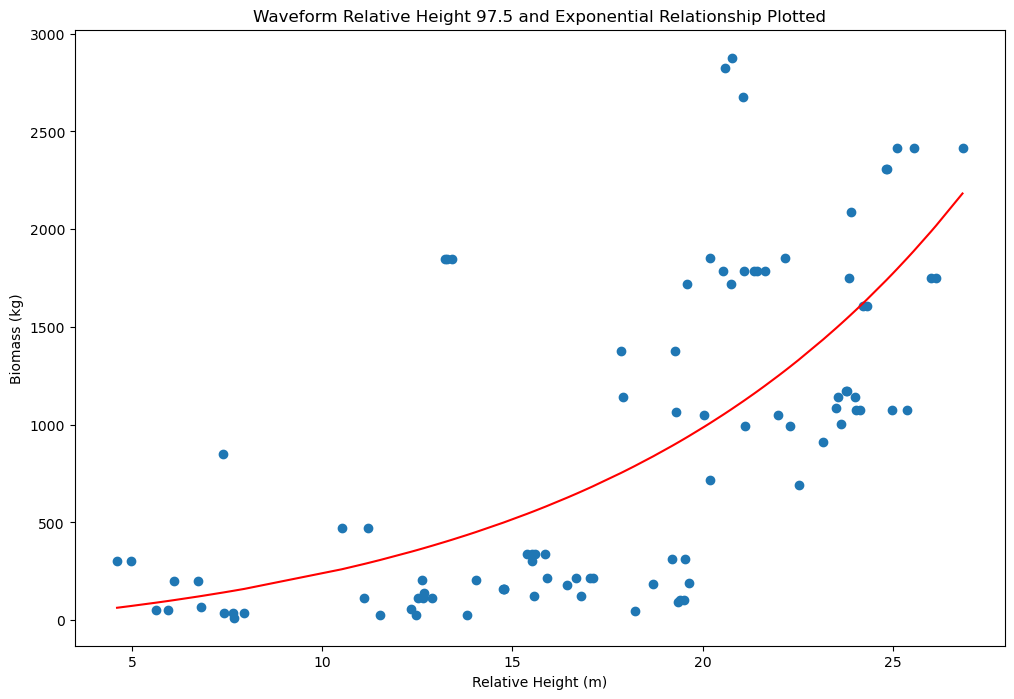

In [89]:
waveform_biomass_data_main_file = "/Users/felixyu/Documents/Remote-Sensing/Neon-Pls-Wvs-Las/data/biomass_waveform_data_main.csv"
perform_regression_main(waveform_biomass_data_main_file)

In [3]:
def perform_general_linear_regression(waveform_canopy_heights, biomass_values, waveform_canopy_graph_heights, graph_title):
    # Fit one linear regression model with all waveforms

    regression_model = LinearRegression().fit(waveform_canopy_heights, biomass_values)
    regression_predictions = regression_model.predict(waveform_canopy_heights)
    
    score = regression_model.score(waveform_canopy_heights, biomass_values)
    rmse = np.sqrt(mean_squared_error(biomass_values, regression_predictions))
    
    print(f"Intercept: {regression_model.intercept_}")
    print(f"Coefficients: {regression_model.coef_}")
    print(f"R^2: {score}")
    print(f"RMSE: {rmse}")

    reg_model_graphing = LinearRegression().fit(waveform_canopy_graph_heights, biomass_values)
    reg_graph_predictions = reg_model_graphing.predict(waveform_canopy_graph_heights)
    sorted_indices = np.argsort(waveform_canopy_graph_heights.flatten())
    sorted_waveform_canopy_heights = waveform_canopy_graph_heights.flatten()[sorted_indices]
    sorted_regression_predictions = reg_graph_predictions[sorted_indices]
    
    fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8))
    ax1.set_title(f'{graph_title}')
    ax1.set_xlabel('Relative Height (m)')
    ax1.set_ylabel('Biomass (kg)')
    ax1.scatter(waveform_canopy_graph_heights, biomass_values, label='Canopy Heights')
    ax1.plot(sorted_waveform_canopy_heights, sorted_regression_predictions, color='red', label='Regression Line')
    ax1.legend()

    # ax2.set_title(f'Waveform Relative Height 10')
    # ax2.set_xlabel('Relative Height (m)')
    # ax2.set_ylabel('Biomass (kg)')
    # ax2.scatter(waveform_canopy_heights_RH10, biomass_values_masked)

    fig.subplots_adjust(wspace=0.5)
    plt.show()

In [87]:
def perform_clustered_linear_regression(waveform_canopy_heights, biomass_values, number_of_clusters, cluster_group_values, clusters_with_no_data, clusters_with_limited_data, split_percentage):
    # Use the indices to create train and test splits for each array
    train_ind_aggr, test_ind_aggr, train_ind_cluster, test_ind_cluster = split_test_train_cluster_indices(cluster_group_values, number_of_clusters, clusters_with_no_data, clusters_with_limited_data, split_percentage)
   
    # Create a linear regression for all the clusters with all data as training
    for i in range(number_of_clusters):
        train_test_indices_aggregate = np.concatenate((train_ind_cluster[i], test_ind_cluster[i]))

        if i in clusters_with_no_data:
            continue

        # if i in clusters_with_limited_data:
        #     fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
        #     ax1.set_title(f'Waveform Relative Height 97.5 vs. Biomass Cluster {i}')
        #     ax1.set_xlabel('Relative Height (m)')
        #     ax1.set_ylabel('Biomass (kg)')
        #     ax1.scatter(waveform_canopy_heights[train_test_indices_aggregate], biomass_values[train_test_indices_aggregate])
        #     continue

        elevation_train_2 = waveform_canopy_heights[train_ind_cluster[i]]
        elevation_test_2 = waveform_canopy_heights[test_ind_cluster[i]]
        elevation_aggregate_2 = waveform_canopy_heights[train_test_indices_aggregate]
            
        cluster_train_2 = cluster_group_values[train_ind_cluster[i]]
        cluster_test_2 = cluster_group_values[test_ind_cluster[i]]
        
        biomass_train_2 = biomass_values[train_ind_cluster[i]]
        biomass_test_2 = biomass_values[test_ind_cluster[i]]
        biomass_aggregate_2 = biomass_values[train_test_indices_aggregate]

        regression_model_2 = LinearRegression().fit(elevation_aggregate_2, biomass_aggregate_2)
        score_2 = regression_model_2.score(elevation_aggregate_2, biomass_aggregate_2)

        print(f"For cluster {i}")
        print(f"Intercept: {regression_model_2.intercept_}")
        print(f"Coefficients: {regression_model_2.coef_}")
        print(f"Score: {score_2}")

        # Plot scatter points used to create regression 
        fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
        ax1.set_title(f'Waveform Relative Height 97.5 vs. Biomass Cluster {i}')
        ax1.set_xlabel('Relative Height (m)')
        ax1.set_ylabel('Biomass (kg)')
        ax1.scatter(waveform_canopy_heights[train_test_indices_aggregate], biomass_values[train_test_indices_aggregate])
        plt.show()

In [64]:
def perform_exponential_regression(waveform_canopy_heights_flattened, biomass_values):
    # Exponential regression in the form of a * np.exp(b * t) + c to RH and biomass
    popt, pcov = curve_fit(lambda t, a, b, c: a * np.exp(b * t) + c, 
                           waveform_canopy_heights_flattened, 
                           biomass_values)
    a = popt[0]
    b = popt[1]
    c = popt[2]
    exponential_fit_curve = a * np.exp(b * waveform_canopy_heights_flattened) + c

    fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8))
    ax1.set_title(f'Waveform Relative Height 97.5 and Exponential Relationship Plotted')
    ax1.set_xlabel('Relative Height (m)')
    ax1.set_ylabel('Biomass (kg)')
    ax1.scatter(waveform_canopy_heights_flattened, biomass_values)
    ax1.plot(np.sort(waveform_canopy_heights_flattened), exponential_fit_curve[np.argsort(waveform_canopy_heights_flattened)], color='red')

    exponential_rmse = np.sqrt(np.mean((biomass_values - exponential_fit_curve)**2))
    print(f"Exponential RMSE: {exponential_rmse}")
    print(f"A: {a}, B: {b}, C: {c}")

RMSE: 710.7737981777622


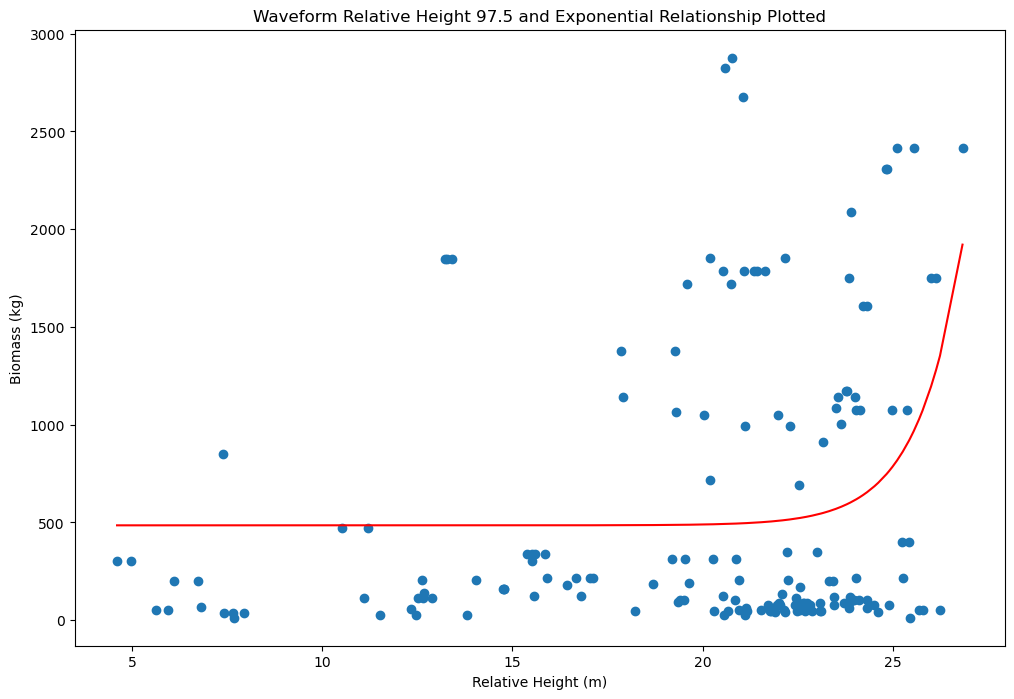

In [39]:
waveform_biomass_data_main_file = "/Users/felixyu/Documents/Remote-Sensing/Neon-Pls-Wvs-Las/data/biomass_waveform_data_main.csv"
perform_exponential_regression(waveform_biomass_data_main_file)

In [30]:
def perform_polynomial_regression(waveform_biomass_data_file):
    waveform_biomass_data = pd.read_csv(waveform_biomass_data_file)

    # DF Variables
    waveforms_with_biomass = waveform_biomass_data.iloc[:, 10:]
    waveform_elevation_data = waveforms_with_biomass.to_numpy()

    cluster_group_values = waveform_biomass_data["Cluster"].to_numpy()
    pulsenumbers = waveform_biomass_data["Pulsenumber"].to_numpy()
    biomass_values = np.array(waveform_biomass_data["Biomass"])
    canopy_top_values = waveform_biomass_data["CanopyTop"].to_numpy()
    canopy_bottom_values = waveform_biomass_data["CanopyBottom"].to_numpy()
    surface_elevation_values = waveform_biomass_data["SurfaceElevation"].to_numpy()

    # Cluster vars
    number_of_clusters = 10
    cluster_group_count = {i: 0 for i in range(number_of_clusters)}
    cluster_regression_scores = {i: 0 for i in range(number_of_clusters)}
    clusters_with_no_data = [2, 4, 5]
    clusters_with_limited_data = []
    split_percentage = 0.25
    
    # Get metrics
    mid_index = waveform_elevation_data.shape[1] // 2
    quarter_index = waveform_elevation_data.shape[1] // 4
    waveform_elevation_RH100 = waveform_elevation_data[:, [-1]]
    waveform_elevation_RH10 = waveform_elevation_data[:, [5]]
    waveform_elevation_RH975_RH100 = waveform_elevation_data[:, [-2, -1]]
    waveform_elevation_RH975 = waveform_elevation_data[:, [-2]]
    waveform_elevation_RH50 = waveform_elevation_data[:, [mid_index]]
    waveform_elevation_RH50_RH975 = waveform_elevation_data[:, [mid_index, -2]]
    waveform_elevation_RH10_RH975 = waveform_elevation_data[:, [5, -2]]
    waveform_elevation_RH25_RH975 = waveform_elevation_data[:, [quarter_index, -2]]

    waveform_RH_start = canopy_bottom_values - surface_elevation_values

    # Filter out waveforms with negative canopy heights
    non_negative_mask = waveform_RH_start >= 0
    waveform_RH_start_filtered = waveform_RH_start[non_negative_mask]
    waveform_elevation_RH10_filtered = waveform_elevation_RH10[non_negative_mask, :]
    waveform_elevation_RH975_filtered = waveform_elevation_RH975[non_negative_mask, :]
    cluster_group_values_filtered = cluster_group_values[non_negative_mask]
    
    biomass_values_masked = biomass_values[non_negative_mask]
    waveform_RH_start_column = waveform_RH_start_filtered.reshape(-1, 1)
    waveform_canopy_heights_RH975 = waveform_RH_start_column + waveform_elevation_RH975_filtered
    waveform_canopy_heights_RH10 = waveform_RH_start_column + waveform_elevation_RH10_filtered
    waveform_canopy_heights_RH975_flattened = waveform_canopy_heights_RH975.flatten()
    waveform_canopy_heights_RH10_RH975 = np.column_stack((waveform_canopy_heights_RH10, waveform_canopy_heights_RH975))

    # Polynomial regression with degree 4
    poly_feat = PolynomialFeatures(degree = 4)
    X_poly = poly_feat.fit_transform(waveform_canopy_heights_RH975)

    reg_model = LinearRegression().fit(X_poly, biomass_values_masked)
    poly_regression_predictions = reg_model.predict(X_poly)
    poly_rmse = np.sqrt(mean_squared_error(biomass_values_masked, poly_regression_predictions))

    # Sort for graphing
    sorted_indices = np.argsort(waveform_canopy_heights_RH975.flatten())
    sorted_waveform_canopy_heights = waveform_canopy_heights_RH975.flatten()[sorted_indices]
    sorted_poly_regression_predictions = poly_regression_predictions[sorted_indices]
    
    fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8))
    ax1.set_title(f'Waveform Relative Height 97.5 and Exponential Relationship Plotted')
    ax1.set_xlabel('Relative Height (m)')
    ax1.set_ylabel('Biomass (kg)')
    ax1.scatter(waveform_canopy_heights_RH975, biomass_values_masked)
    ax1.plot(sorted_waveform_canopy_heights, sorted_poly_regression_predictions, color='red')

    print(f"RMSE: {poly_rmse}")

RMSE: 706.4448529882496


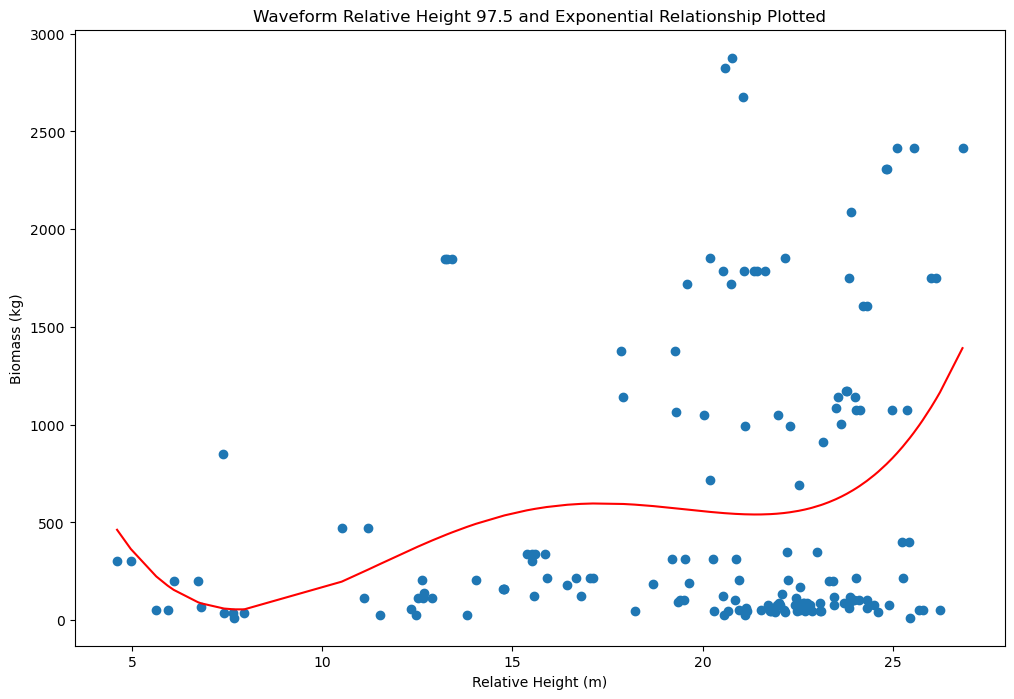

In [41]:
waveform_biomass_data_main_file = "/Users/felixyu/Documents/Remote-Sensing/Neon-Pls-Wvs-Las/data/biomass_waveform_data_main.csv"
perform_polynomial_regression(waveform_biomass_data_main_file)

In [8]:
mapping_tagging_table = "/Users/felixyu/Documents/Remote-Sensing/Field-Data/Field-Data-CSV/HARV-08-2019/vst_mappingandtagging_harv_2019_08.csv"
apparent_individual_table = "/Users/felixyu/Documents/Remote-Sensing/Field-Data/Field-Data-CSV/HARV-08-2019/vst_apparentindividual_2019_08.csv"
calculate_total_tree_biomass(4704085, 727091, 2, mapping_tagging_table, apparent_individual_table)

NameError: name 'calculate_total_tree_biomass' is not defined

In [55]:
def cumulative_waveform_analysis_main(waveform_file, waveform_start_index, waveform_finish_index, biomass_group_num):
    
    # Reading files vars
    waveform_files = waveform_file.split('.')
    pls_file = waveform_files[0] + '.pls'
    wvs_file = waveform_files[0] + '.wvs'
    readbin_pls_file = open(pls_file,"rb")
    readbin_pls_file.seek(0,0)
    readbin_wvs_file = open(wvs_file,"rb")
    readbin_wvs_file.seek(0,0)
    waveform_file_name = waveform_file.split("_")[4]
    
    # Easting, northing, and resolution vars
    min_easting_range = float('inf')
    max_easting_range = float('-inf')
    min_northing_range = float('inf')
    max_northing_range = float('-inf')
    distances_between_waveform_easting = []
    distances_between_waveform_northing = []
    avg_waveform_distance_easting = 0
    avg_waveform_distance_northing = 0
    waveform_easting_values = []
    waveform_northing_values = []
    # waveform_numbers = []
    
    waveform_cum_energy = []
    original_waveforms_intensity = []
    original_waveforms_elevation = []
    total_num_multiple_segments = 0
    prev_waveform_easting = 0
    prev_waveform_northing = 0

    # Biomass vars
    mapping_tagging_table = "/Users/felixyu/Documents/Remote-Sensing/Field-Data/Field-Data-CSV/HARV-08-2019/vst_mappingandtagging_harv_2019_08.csv"
    apparent_individual_table = "/Users/felixyu/Documents/Remote-Sensing/Field-Data/Field-Data-CSV/HARV-08-2019/vst_apparentindividual_2019_08.csv"
    biomass_northing = 0
    biomass_easting = 0
    resolution = 1
    count = 0
    shot_numbers_with_existing_biomass = []
    waveform_easting_biomass_found = []
    waveform_northing_biomass_found = []
    total_biomass_nums = []

    # Biomass geolocation groups: Easting min, easting max, northing min, northing max
    group_1_geolocation = [732106, 732147, 4713825, 4713844]
    group_2_geolocation = [723926, 723944, 4707713, 4707732]
    group_3_geolocation = [727586, 727605, 4704386, 4704405]
    group_4_geolocation = [727077, 727097, 4704083, 4704104]
    group_5_geolocation = [728124, 728143, 4702855, 4702877]
    group_6_geolocation = [727049, 727066, 4701145, 4701163]
    group_7_geolocation = [727884, 727902, 4700908, 4700925]
    group_8_geolocation = [725546, 725566, 4700513, 4700534]
    group_9_geolocation = [726500, 726521, 4699044, 4699063]
    group_10_geolocation = [725997, 726016, 4698177, 4698195]
    group_11_geolocation = [725964, 725986, 4696973, 4696994]
    all_grouped_biomass_locations = np.array([group_1_geolocation,
                                    group_2_geolocation,
                                    group_3_geolocation,
                                    group_4_geolocation,
                                    group_5_geolocation,
                                    group_6_geolocation,
                                    group_7_geolocation,
                                    group_8_geolocation,
                                    group_9_geolocation,
                                    group_10_geolocation,
                                    group_11_geolocation])

    # Save biomass geolocation into csv
    # biomass_df = pd.DataFrame({'Easting': biomass_easting_arr, 'Northing': biomass_northing_arr})
    # biomass_df.to_csv("valid_biomass_geolocation_info.csv", index=False)

    # Read pls file
    instrument_name, number_of_pulses, xyz_origin_array, dxdydz_array, xyz_bin0_array, xyz_lastbin_array, \
    offset_to_pulse_data, pulse_size, T_scale_factor, T_offset, x_scale_factor, x_offset, y_scale_factor, y_offset, \
    z_scale_factor, z_offset, sampling_record_pulse_descriptor_index_lookup_array, pulse_descriptor_optical_center_to_anchor_point_array, \
    pulse_descriptor_number_of_extra_wave_bytes_array, pulse_descriptor_number_of_samplings_array, \
    sampling_record_bits_for_duration_from_anchor_array, sampling_record_scale_for_duration_from_anchor_array, \
    sampling_record_offset_for_duration_from_anchor_array, sampling_record_bits_for_number_of_segments_array, \
    sampling_record_bits_for_number_of_samples_array, sampling_record_number_of_segments_array, \
    sampling_record_number_of_samples_array, sampling_record_bits_per_sample_array = read_NEONAOP_pulsewaves_pulse_information(pls_file) 
    
    # Save waveform data into main csv file
    waveform_elevation_axis_numbers = np.round(np.arange(0, 1.01, 0.025), 3)
    columns = ['FileName', 'Pulsenumber', 'Biomass', 'Easting', 'Northing', 'Group', 'Cluster'] + [f"Elevation_{i}" for i in waveform_elevation_axis_numbers]
    
    biomass_waveform_df = pd.DataFrame(columns=columns)
    
    start_t = time.time()
    # Get biomass geolocation information
    biomass_northing_arr, biomass_easting_arr, biomass_id_arr, biomass_count = print_apparent_individual_biomass_information(apparent_individual_table, mapping_tagging_table, resolution, False)

    waveform_start_index_copy = waveform_start_index
    while waveform_start_index <= waveform_finish_index:
        # Read waveform
        waveform, waveform_x_axis, waveform_y_axis, waveform_z_axis, offset, multiple_segments_bool = read_NEONAOP_pulsewaves_waveform(readbin_pls_file,readbin_wvs_file,waveform_start_index,offset_to_pulse_data,pulse_size,T_scale_factor,T_offset,x_scale_factor,x_offset,y_scale_factor,y_offset,z_scale_factor,z_offset,sampling_record_pulse_descriptor_index_lookup_array,pulse_descriptor_optical_center_to_anchor_point_array,pulse_descriptor_number_of_extra_wave_bytes_array,pulse_descriptor_number_of_samplings_array,sampling_record_bits_for_duration_from_anchor_array,sampling_record_scale_for_duration_from_anchor_array,sampling_record_offset_for_duration_from_anchor_array,sampling_record_bits_for_number_of_segments_array,sampling_record_bits_for_number_of_samples_array,sampling_record_number_of_segments_array,sampling_record_number_of_samples_array,sampling_record_bits_per_sample_array)
        cur_waveform_avg_easting = np.mean(waveform_x_axis)
        cur_waveform_avg_northing = np.mean(waveform_y_axis)

        if multiple_segments_bool:
            total_num_multiple_segments += 1

        # Calculate distance between waveform for resolution
        if count != 0:
            distance_between_waveform_easting = abs(cur_waveform_avg_easting - prev_waveform_easting)
            distance_between_waveform_northing = abs(cur_waveform_avg_northing - prev_waveform_northing)
            distances_between_waveform_easting.append(distance_between_waveform_easting)
            distances_between_waveform_northing.append(distance_between_waveform_northing)

        waveform_min_easting = waveform_x_axis.min()
        waveform_max_easting = waveform_x_axis.max()
        waveform_min_northing = waveform_y_axis.min()
        waveform_max_northing = waveform_y_axis.max()
        indv_waveform_easting_geolocation = np.mean([waveform_min_easting, waveform_max_easting])
        indv_waveform_northing_geolocation = np.mean([waveform_min_northing, waveform_max_northing])
        # waveform_easting_values.append(indv_waveform_easting_geolocation)
        # waveform_northing_values.append(indv_waveform_northing_geolocation)
        # waveform_numbers.append(waveform_start_index)
        
        min_easting_range = min(min_easting_range, waveform_min_easting)
        max_easting_range = max(max_easting_range, waveform_max_easting)
        min_northing_range = min(min_northing_range, waveform_min_northing)
        max_northing_range = max(max_northing_range, waveform_max_northing)
        
        # Evaluate waveform
        waveform_intensity_threshold = 20.0
        
        # Peak location indices
        # return_location_count, return_peak_location_list, return_location_list_x, return_intensity_list = waveform_peak_detection(waveform,waveform_intensity_threshold)
        waveform_energy_elev_arr = normalize_cumulative_return_energy(waveform, waveform_z_axis, False)
        original_waveforms_intensity.append(waveform)
        original_waveforms_elevation.append(waveform_z_axis)
        
        # Interesting observation: length is either 80, 96, 112, or 240 (multiple segments in 240) so 40, 48, 56, or 120 values
        waveform_cum_energy.append(waveform_energy_elev_arr)

        # See if waveform biomass exists
        # biomass_group_found, biomass_group_number = find_associated_biomass_waveform_group(waveform_x_axis, waveform_y_axis, all_grouped_biomass_locations, waveform_start_index)
        biomass_found, biomass_waveform_easting, biomass_waveform_northing = find_associated_biomass_waveform_pulse_number(biomass_northing_arr, biomass_easting_arr, waveform_x_axis, waveform_y_axis, waveform_start_index, False)
        if biomass_found:
            shot_numbers_with_existing_biomass.append(waveform_start_index)
            waveform_easting_biomass_found.append(biomass_waveform_easting)
            waveform_northing_biomass_found.append(biomass_waveform_northing)
            waveform_easting_values.append(indv_waveform_easting_geolocation)
            waveform_northing_values.append(indv_waveform_northing_geolocation)

            # This is for a variable resolution (smaller). For now keep it at 1m
            # waveform_resolution = max(waveform_max_easting - waveform_min_easting, waveform_max_northing - waveform_min_northing)
            # print(waveform_resolution)
            waveform_resolution = 1.5
            biomass_num = calculate_total_tree_biomass(indv_waveform_northing_geolocation, indv_waveform_easting_geolocation, waveform_resolution, mapping_tagging_table, apparent_individual_table)

            if biomass_num < 1.0:
                print(f"No biomass found for waveform {waveform_start_index}")
                waveform_start_index += 1
                continue
            total_biomass_nums.append(biomass_num)
            
            # Interpolate waveform data for RH metrics
            # Comment these underneath if not building main data table
            interpolated_wf, outlier_bool = interpolate_waveform_values(waveform_energy_elev_arr, False)
            new_biomass_row = add_waveform_data_row_with_biomass(waveform_file_name, interpolated_wf, indv_waveform_easting_geolocation, indv_waveform_northing_geolocation, biomass_num, 0, waveform_start_index, biomass_group_num)
            
            # Ensure both new biomass row and overarching biomass have same exact columns
            # new_biomass_row = new_biomass_row.reindex(columns=biomass_waveform_df.columns)
            # biomass_waveform_df = biomass_waveform_df.reset_index(drop=True)
            # new_biomass_row = new_biomass_row.reset_index(drop=True)
            # print(new_biomass_row)
            # Add information to main dataframe
            biomass_waveform_df = pd.concat([biomass_waveform_df, new_biomass_row], ignore_index=True)
            # print(biomass_waveform_df)
            
        prev_waveform_easting = cur_waveform_avg_easting
        prev_waveform_northing = cur_waveform_avg_northing
        waveform_start_index += 1
        count += 1
    end_t = time.time()
    
    print(f"Processing biomass times: {end_t - start_t}")
    # print(shot_numbers_with_existing_biomass)
    print(total_biomass_nums)
    # Save geolocation of waveforms
    # waveform_location_df = pd.DataFrame({'Pulsenumber': waveform_numbers, 'Easting': waveform_easting_values, 'Northing': waveform_northing_values})
    # waveform_location_df.to_csv("waveform_geolocation_info.csv", index=False)
    
    # Save main biomass waveform data - CHANGE NAME FOR EACH GROUP
    # print(biomass_waveform_df.dtypes)
    # biomass_waveform_df.to_csv(f"biomass_waveform_data_main_group_{biomass_group_num}_{waveform_file_name}_copy.csv", index=False)

    
    # Range of all the waveforms
    print(f"Easting range: {min_easting_range} to {max_easting_range}")
    print(f"Northing range: {min_northing_range} to {max_northing_range}")
    print(f"Average easting resolution between waveforms: {np.mean(distances_between_waveform_easting)}")
    print(f"Average northing resolution between waveforms: {np.mean(distances_between_waveform_northing)}")
    print(f"Max easting resolution between waveforms: {np.max(distances_between_waveform_easting)}")
    print(f"Max northing resolution between waveforms: {np.max(distances_between_waveform_northing)}")


    # Interpolate all waveforms to the same size
    interpolated_waveforms = []
    for waveform in waveform_cum_energy:
        interpolated_wf_one, outlier = interpolate_waveform_values(waveform, False)
        interpolated_waveforms.append(interpolated_wf_one)
    interpolated_waveforms = np.array(interpolated_waveforms)


    # Interpolate the waveforms of biomass waveforms
    
    # Calculate slopes of signal vs. relative elevation to perform outlier detection
    waveform_0_25_slopes = calculate_cumulative_signal_slopes(interpolated_waveforms, 0.0, 0.25)
    waveform_25_50_slopes = calculate_cumulative_signal_slopes(interpolated_waveforms, 0.25, 0.5)
    waveform_50_75_slopes = calculate_cumulative_signal_slopes(interpolated_waveforms, 0.5, 0.75)
    waveform_75_100_slopes = calculate_cumulative_signal_slopes(interpolated_waveforms, 0.75, 1.0)
    
    # check_normality(waveform_0_25_slopes, False)
    # check_normality(waveform_25_50_slopes, False)
    # check_normality(waveform_50_75_slopes, False)
    # check_normality(waveform_75_100_slopes, False)

    outlier_0_25 = perform_normal_waveform_outlier_analysis(waveform_0_25_slopes)
    outlier_25_50 = perform_normal_waveform_outlier_analysis(waveform_25_50_slopes)
    outlier_50_75 = perform_normal_waveform_outlier_analysis(waveform_50_75_slopes)
    outlier_75_100 = perform_normal_waveform_outlier_analysis(waveform_75_100_slopes)

    outliers_aggregated = np.unique(np.concatenate([outlier_0_25, outlier_25_50, outlier_50_75, outlier_75_100]))
    waveform_outliers = interpolated_waveforms[outliers_aggregated]
    # print(len(waveform_outliers))
    # print(total_num_multiple_segments)

    filtered_waveforms = np.delete(interpolated_waveforms, outliers_aggregated, axis=0)
    
    # print(f"Northing Min: {np.min(biomass_northing_arr)}")
    # print(f"Northing Max: {np.max(biomass_northing_arr)}")
    # print(f"Easting Min: {np.min(biomass_easting_arr)}")
    # print(f"Easting Max: {np.max(biomass_easting_arr)}")
    
    # biomass = calculate_total_tree_biomass(biomass_northing, biomass_easting, resolution, mapping_tagging_table, apparent_individual_table)
    # print(biomass)
    # Plot outliers with all waveforms
    plt.figure(figsize=(12,8))
    plt.title("Waveform Outliers")
    plt.xlabel("Normalized Cumulative Signal Level")
    plt.ylabel("Relative Elevation (m)")
    print(len(waveform_outliers))
    for waveform in waveform_outliers:
        plt.plot(waveform[0::2], waveform[1::2], color='red')
    for waveform in filtered_waveforms:
        plt.plot(waveform[0::2], waveform[1::2], color='lightgray')
    plt.show()

    # Plot outlier's original waveform    
    # plotting_waveform_index = 100
    # waveform_example = interpolated_waveforms[outliers_aggregated[plotting_waveform_index]]
    # original_waveform_elevation = original_waveforms_elevation[outliers_aggregated[plotting_waveform_index]]
    # original_waveform_intensity = original_waveforms_intensity[outliers_aggregated[plotting_waveform_index]]

    # fig, (ax1, ax2) = plt.subplots(2, figsize=(8,8))
    # ax1.set_title("Cumulative Signal Return Level Outlier")
    # ax1.set_xlabel("Normalized Cumulative Signal Level")
    # ax1.set_ylabel("Relative Elevation (M)")
    # ax1.plot(waveform_example[0::2], waveform_example[1::2])

    # ax2.set_title("Original Waveform Plot")
    # ax2.set_xlabel("Signal Level")
    # ax2.set_ylabel("Elevation")
    # ax2.plot(original_waveform_intensity, original_waveform_elevation)
    
    # plt.tight_layout()
    # plt.show()

    # for waveform in waveform_outliers:
    #     plt.plot(waveform[0::2], waveform[1::2], color='red')
    # for waveform in filtered_waveforms:
    #     plt.plot(waveform[0::2], waveform[1::2], color='lightgray')
    # plt.show()

Total individual data count: 279
Processing biomass times: 4.07296895980835
[]
Easting range: 727190.3661499996 to 727817.2758000003
Northing range: 4695772.836099997 to 4695818.158849999
Average easting resolution between waveforms: 1.5418316413354516
Average northing resolution between waveforms: 0.07558567165055623
Max easting resolution between waveforms: 56.107174999429844
Max northing resolution between waveforms: 2.591225003823638
64


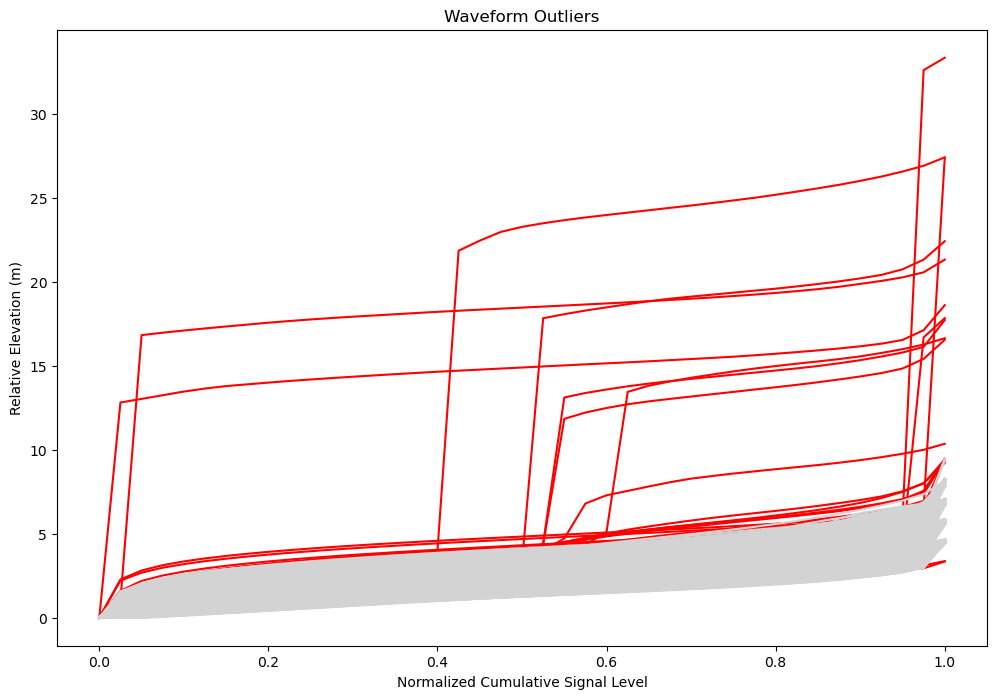

In [42]:
waveform_file_L022 = '/Users/felixyu/Documents/Remote-Sensing/Neon-Pls-Wvs-Las/data/NEON_D01_HARV_DP1_L022-1_2019082013_1.pls'
waveform_file_L019 = '/Users/felixyu/Documents/Remote-Sensing/Neon-Pls-Wvs-Las/data/NEON_D01_HARV_DP1_L019-1_2019082013_1.pls'
waveform_file_L018 = '/Users/felixyu/Documents/Remote-Sensing/Neon-Pls-Wvs-Las/data/NEON_D01_HARV_DP1_L018-1_2019082013_1.pls'

cumulative_waveform_analysis_main(waveform_file_L019, 0, 15000, 4)
# Group 8: 3,592,888 - 3615790
# Northing range: 4703619.0978 to 4704008.779499999
# Easting range: 726059.4086200006 to 726883.37525
# Northing range: 4695707.48043 to 4696663.511
# 500,000 - 100,000
# Easting range: 726133.0999 to 726957.2770600003
# Northing range: 4696646.919969996 to 4697159.7633500025
# Easting range: 725952.2486900002 to 726725.9793199999

In [28]:
def save_waveform_height_data(wave_file, start_index, end_index, waveform_nums):
    
    waveform_files = wave_file.split('.')
    pls_file = waveform_files[0] + '.pls'
    wvs_file = waveform_files[0] + '.wvs'
    readbin_pls_file = open(pls_file,"rb")
    readbin_pls_file.seek(0,0)
    readbin_wvs_file = open(wvs_file,"rb")
    readbin_wvs_file.seek(0,0)
    waveform_file_name = wave_file.split("_")[4]
    print(waveform_file_name)
    waveform_height_df = pd.DataFrame(columns=["PulseNumber", "CanopyBottom", "CanopyTop"])
    
    instrument_name, number_of_pulses, xyz_origin_array, dxdydz_array, xyz_bin0_array, xyz_lastbin_array, \
    offset_to_pulse_data, pulse_size, T_scale_factor, T_offset, x_scale_factor, x_offset, y_scale_factor, y_offset, \
    z_scale_factor, z_offset, sampling_record_pulse_descriptor_index_lookup_array, pulse_descriptor_optical_center_to_anchor_point_array, \
    pulse_descriptor_number_of_extra_wave_bytes_array, pulse_descriptor_number_of_samplings_array, \
    sampling_record_bits_for_duration_from_anchor_array, sampling_record_scale_for_duration_from_anchor_array, \
    sampling_record_offset_for_duration_from_anchor_array, sampling_record_bits_for_number_of_segments_array, \
    sampling_record_bits_for_number_of_samples_array, sampling_record_number_of_segments_array, \
    sampling_record_number_of_samples_array, sampling_record_bits_per_sample_array = read_NEONAOP_pulsewaves_pulse_information(pls_file) 

    while start_index <= end_index:
        if start_index in waveform_nums:
            waveform, waveform_x_axis, waveform_y_axis, waveform_z_axis, offset, multiple_segments_bool = read_NEONAOP_pulsewaves_waveform(readbin_pls_file,readbin_wvs_file,start_index,offset_to_pulse_data,pulse_size,T_scale_factor,T_offset,x_scale_factor,x_offset,y_scale_factor,y_offset,z_scale_factor,z_offset,sampling_record_pulse_descriptor_index_lookup_array,pulse_descriptor_optical_center_to_anchor_point_array,pulse_descriptor_number_of_extra_wave_bytes_array,pulse_descriptor_number_of_samplings_array,sampling_record_bits_for_duration_from_anchor_array,sampling_record_scale_for_duration_from_anchor_array,sampling_record_offset_for_duration_from_anchor_array,sampling_record_bits_for_number_of_segments_array,sampling_record_bits_for_number_of_samples_array,sampling_record_number_of_segments_array,sampling_record_number_of_samples_array,sampling_record_bits_per_sample_array)

            canopy_top = waveform_z_axis[0]
            canopy_bottom = waveform_z_axis[-1]
            waveform_height_df.loc[len(waveform_height_df)] = [start_index, canopy_bottom, canopy_top]
        start_index += 1 
            
    waveform_height_df.to_csv(f"waveform_elevations_{waveform_file_name}.csv", index=False)
    return

In [23]:
waveform_file_L022 = '/Users/felixyu/Documents/Remote-Sensing/Neon-Pls-Wvs-Las/data/NEON_D01_HARV_DP1_L022-1_2019082013_1.pls'
waveform_file_L019 = '/Users/felixyu/Documents/Remote-Sensing/Neon-Pls-Wvs-Las/data/NEON_D01_HARV_DP1_L019-1_2019082013_1.pls'
waveform_file_L018 = '/Users/felixyu/Documents/Remote-Sensing/Neon-Pls-Wvs-Las/data/NEON_D01_HARV_DP1_L018-1_2019082013_1.pls'

L018_group_5 = [7096981, 7097862, 7097863, 7097864, 7097865, 7098199, 7098200, 7098201, 7098202, 7100748, 7101638, 7101642, 7101643, 7101644, 7101979, 7101980, 7106772, 7107653, 7110118, 7110391, 7110393, 7116381, 7116382, 7116383, 7116386, 7116387, 7117343, 7117346, 7117347]
L018_group_7 = [4735586, 4738586, 4738587, 4739580, 4739777, 4740592, 4740593, 4740594, 4740799, 4743571, 4744876, 4747752, 4747753, 4748014]
L019_group_6 = [4719060, 4719061, 4719283, 4719284, 4722245, 4725408, 4725618, 4725619, 4733763, 4734525, 4735518, 4735519, 4735701, 4736478, 4736688, 4738557, 4738760, 4739557, 4739558]
L019_group_4 = [8367850, 8368553, 8369827, 8371033, 8371038, 8371046, 8371641, 8372299,
                8372310, 8372888, 8373529, 8373530, 8373536, 8373537, 8374098, 8374104, 8374746, 8374753,
                8374754, 8374755, 8374756, 8375287, 8377071, 8377088, 8377636, 8378304, 8378305, 8378322,
                8378323, 8378864, 8378865, 8379559, 8379560, 8380126, 8380784, 8380785, 8380794, 8380795,
                8381330, 8381331, 8381340, 8382015, 8384537, 8385141, 8386442, 8386443, 8387125, 8387685,
                8387690, 8387691, 8388362, 8388363, 8388882, 8390063, 8390064, 8390692, 8391246, 8391247,
                8391249, 8391878, 8391879, 8392421, 8392422, 8393652, 8393668, 8394343, 8394362, 8394911,
                8394912, 8394927, 8396759]
L022_group_9 = [3593621, 3594168, 3594173, 3594865, 3594867, 3595415, 3595418, 3595429,
                3595431, 3595432, 3596172, 3596175, 3596684, 3596689, 3597452, 3597974,
                3597975, 3598661, 3599204, 3599205, 3599222, 3599223, 3601511, 3603401,
                3603905, 3604614, 3605184, 3605193, 3605196, 3605885, 3605886, 3605888,
                3605891, 3605892, 3605899, 3606424, 3606438, 3607137, 3610149, 3610150,
                3612645, 3612646, 3612647, 3613295, 3613296, 3613297, 3613862, 3614534,
                3614535]

save_waveform_height_data(waveform_file_L018, 7096981, 7117347, L018_group_5)

L018-1


In [29]:
def get_surface_elevations(waveform_file_df, dtm_list, dtm_folder):
    pulse_numbers = []
    surface_elevation_numbers = []
    canopy_heights = []
    
    for row in waveform_file_df.itertuples():
        easting = row.Easting
        northing = row.Northing
        pulsenumber = row.Pulsenumber
        canopy_elevation = row.CanopyTop

        for file in dtm_list:
            file_easting = int(file.split("_")[4])
            file_northing = int(file.split("_")[5])

            easting_rounded = int(math.floor(easting / 1000) * 1000)
            northing_rounded = int(math.floor(northing / 1000) * 1000)

            if easting_rounded == file_easting and northing_rounded == file_northing:
                xds = rxr.open_rasterio(dtm_folder + file)
                surface_elevation = xds.interp(x=easting, y=northing, band=1).values

                pulse_numbers.append(pulsenumber)
                surface_elevation_numbers.append(surface_elevation)
                
                
    return pulse_numbers, surface_elevation_numbers

In [41]:
dtm_folder = "/Users/felixyu/Documents/Remote-Sensing/Neon-Pls-Wvs-Las/data/NEON_Biomass_Surface_Elevation/"
dtm_files = ["NEON_D01_HARV_DP3_726000_4699000_DTM.tif", "NEON_D01_HARV_DP3_727000_4700000_DTM.tif", "NEON_D01_HARV_DP3_727000_4701000_DTM.tif", "NEON_D01_HARV_DP3_727000_4704000_DTM.tif", "NEON_D01_HARV_DP3_728000_4702000_DTM.tif", "NEON_D01_HARV_DP3_728000_4703000_DTM.tif"]
waveform_df = pd.read_csv("/Users/felixyu/Documents/Remote-Sensing/Neon-Pls-Wvs-Las/data/biomass_waveform_data_main.csv")

pulsenums, surface_elevations = get_surface_elevations(waveform_df, dtm_files, dtm_folder)
surface_elevations_df = pd.DataFrame({"Pulsenumber": pulsenums, "SurfaceElevation": surface_elevations})
surface_elevations_df.to_csv("surface_elevation_data.csv")

Warning 1: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
Warning 1: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
Warning 1: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
Warning 1: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
Warning 1: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
Warning 1: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
Warning 1: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
Warning 1: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
Warning 1: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
Warning 1: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted

In [56]:
def get_cumulative_return_curves(waveform_pulsewaves_start_arr, waveform_pulsewaves_end_arr, pls_file, wvs_file):
    min_easting_range = float('inf')
    max_easting_range = float('-inf')
    min_northing_range = float('inf')
    max_northing_range = float('-inf')
    distances_between_waveform_easting = []
    distances_between_waveform_northing = []
    avg_waveform_distance_easting = 0
    avg_waveform_distance_northing = 0
    prev_waveform_easting = 0
    prev_waveform_northing = 0

    pulsewaves_start = waveform_pulsewaves_start_arr[0]
    current_pulsewaves_batch_counter = 0  
    
    readbin_pls_file = open(pls_file, "rb")
    readbin_pls_file.seek(0, 0)

    readbin_wvs_file = open(wvs_file, "rb")
    readbin_wvs_file.seek(0, 0)
    
    waveform_cum_energy = []

    # Read PLS file
    instrument_name, number_of_pulses, xyz_origin_array, dxdydz_array, xyz_bin0_array, xyz_lastbin_array, \
    offset_to_pulse_data, pulse_size, T_scale_factor, T_offset, x_scale_factor, x_offset, y_scale_factor, y_offset, \
    z_scale_factor, z_offset, sampling_record_pulse_descriptor_index_lookup_array, pulse_descriptor_optical_center_to_anchor_point_array, \
    pulse_descriptor_number_of_extra_wave_bytes_array, pulse_descriptor_number_of_samplings_array, \
    sampling_record_bits_for_duration_from_anchor_array, sampling_record_scale_for_duration_from_anchor_array, \
    sampling_record_offset_for_duration_from_anchor_array, sampling_record_bits_for_number_of_segments_array, \
    sampling_record_bits_for_number_of_samples_array, sampling_record_number_of_segments_array, \
    sampling_record_number_of_samples_array, sampling_record_bits_per_sample_array = read_NEONAOP_pulsewaves_pulse_information(pls_file)

    loop_count = 0
    while pulsewaves_start < waveform_pulsewaves_end_arr[len(waveform_pulsewaves_end_arr)-1]:
        
        # Read waveform
        waveform, waveform_x_axis, waveform_y_axis, waveform_z_axis, offset, multiple_segments_bool = read_NEONAOP_pulsewaves_waveform(readbin_pls_file,readbin_wvs_file,pulsewaves_start,offset_to_pulse_data,pulse_size,T_scale_factor,T_offset,x_scale_factor,x_offset,y_scale_factor,y_offset,z_scale_factor,z_offset,sampling_record_pulse_descriptor_index_lookup_array,pulse_descriptor_optical_center_to_anchor_point_array,pulse_descriptor_number_of_extra_wave_bytes_array,pulse_descriptor_number_of_samplings_array,sampling_record_bits_for_duration_from_anchor_array,sampling_record_scale_for_duration_from_anchor_array,sampling_record_offset_for_duration_from_anchor_array,sampling_record_bits_for_number_of_segments_array,sampling_record_bits_for_number_of_samples_array,sampling_record_number_of_segments_array,sampling_record_number_of_samples_array,sampling_record_bits_per_sample_array)
        cur_waveform_avg_easting = np.mean(waveform_x_axis)
        cur_waveform_avg_northing = np.mean(waveform_y_axis)
    
        # Calculate distance between waveform for resolution
        if loop_count != 0:
            distance_between_waveform_easting = abs(cur_waveform_avg_easting - prev_waveform_easting)
            distance_between_waveform_northing = abs(cur_waveform_avg_northing - prev_waveform_northing)
            distances_between_waveform_easting.append(distance_between_waveform_easting)
            distances_between_waveform_northing.append(distance_between_waveform_northing)

            prev_waveform_easting = cur_waveform_avg_easting
            prev_waveform_northing = cur_waveform_avg_northing
    
        waveform_min_easting = waveform_x_axis.min()
        waveform_max_easting = waveform_x_axis.max()
        waveform_min_northing = waveform_y_axis.min()
        waveform_max_northing = waveform_y_axis.max()
        
        min_easting_range = min(min_easting_range, waveform_min_easting)
        max_easting_range = max(max_easting_range, waveform_max_easting)
        min_northing_range = min(min_northing_range, waveform_min_northing)
        max_northing_range = max(max_northing_range, waveform_max_northing)
        
        waveform_energy_elev_arr = normalize_cumulative_return_energy(waveform, waveform_z_axis, False)
        
        # Interesting observation: length is either 80, 96, 112, or 240 (multiple segments in 240) so 40, 48, 56, or 120 values
        waveform_cum_energy.append(waveform_energy_elev_arr)
        if (current_pulsewaves_batch_counter + 1) < len(waveform_pulsewaves_end_arr) and pulsewaves_start == waveform_pulsewaves_end_arr[current_pulsewaves_batch_counter]:
            current_pulsewaves_batch_counter += 1
            pulsewaves_start = waveform_pulsewaves_start_arr[current_pulsewaves_batch_counter]
        else:
            pulsewaves_start += 1
            loop_count += 1
            
    print(pls_file)
    print(f"Easting range: {min_easting_range} to {max_easting_range}")
    print(f"Northing range: {min_northing_range} to {max_northing_range}")
    print(f"Average easting resolution between waveforms: {np.mean(distances_between_waveform_easting)}")
    print(f"Average northing resolution between waveforms: {np.mean(distances_between_waveform_northing)}")
    print(f"Max easting resolution between waveforms: {np.max(distances_between_waveform_easting)}")
    print(f"Max northing resolution between waveforms: {np.max(distances_between_waveform_northing)}")
    print(f"Total size of energy arr: {len(waveform_cum_energy)}")
    return waveform_cum_energy

/Users/felixyu/Documents/Remote-Sensing/Neon-Pls-Wvs-Las/data/NEON_D01_HARV_DP1_L022-1_2019082013_1.pls
Easting range: 726148.0750999994 to 726829.5
Northing range: 4699014.702850001 to 4699136.054709998
Average easting resolution between waveforms: 8.437819013990584
Average northing resolution between waveforms: 47.06228932000027
Max easting resolution between waveforms: 726566.0711849995
Max northing resolution between waveforms: 4699034.650570001
Total size of energy arr: 100000
/Users/felixyu/Documents/Remote-Sensing/Neon-Pls-Wvs-Las/data/NEON_D01_HARV_DP1_L018-1_2019082013_1.pls
Easting range: 727600.40655 to 728640.6800999999
Northing range: 4701032.413599998 to 4702917.794369998
Average easting resolution between waveforms: 4.96748778270017
Average northing resolution between waveforms: 23.617501257130314
Max easting resolution between waveforms: 728387.5145549998
Max northing resolution between waveforms: 4701044.559290003
Total size of energy arr: 200001
/Users/felixyu/Documen

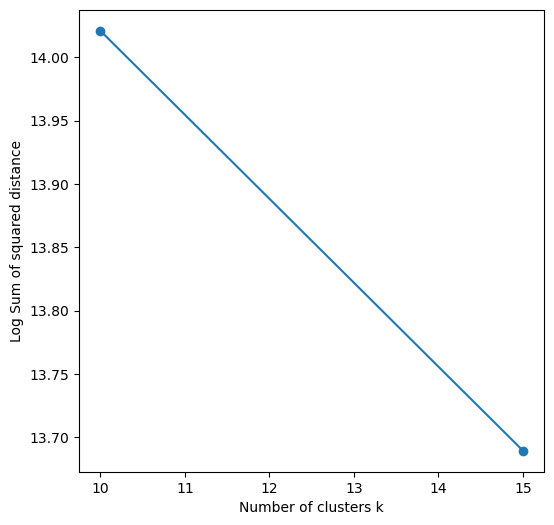

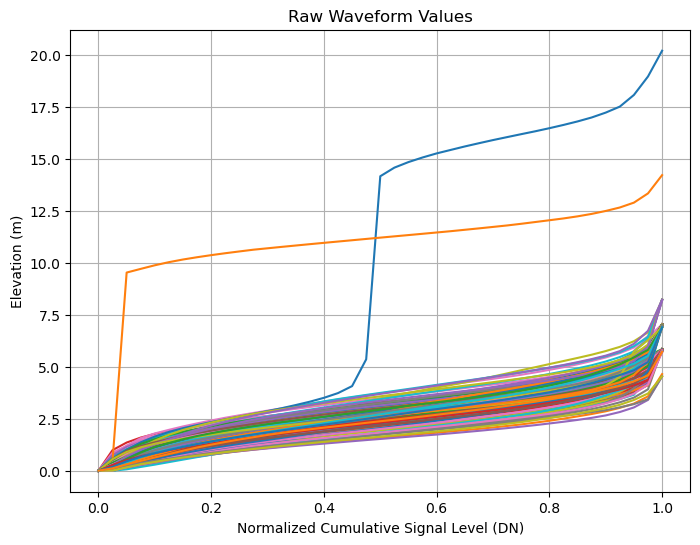

K: 10 Silhouette Score: 0.2807558310330318, Davies Bouldin Score: 0.9107873565021232
K: 15 Silhouette Score: 0.284549148099158, Davies Bouldin Score: 0.7861986762853187


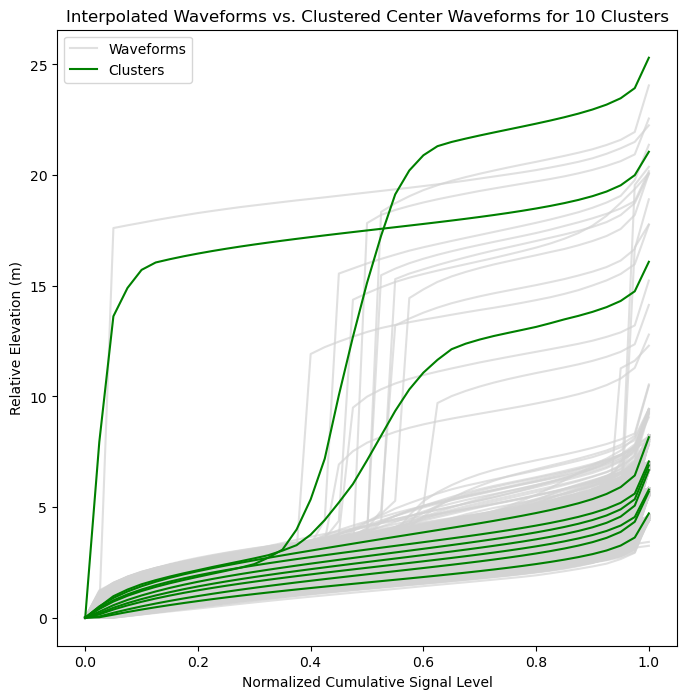

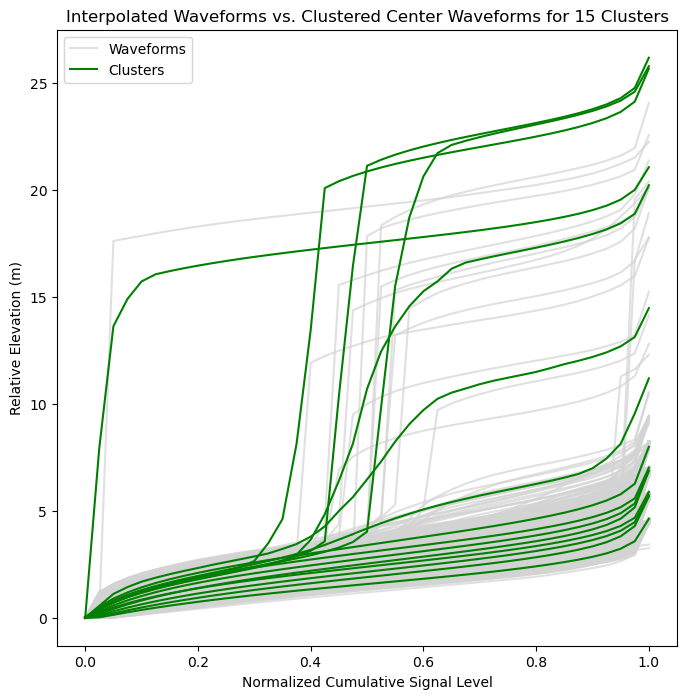

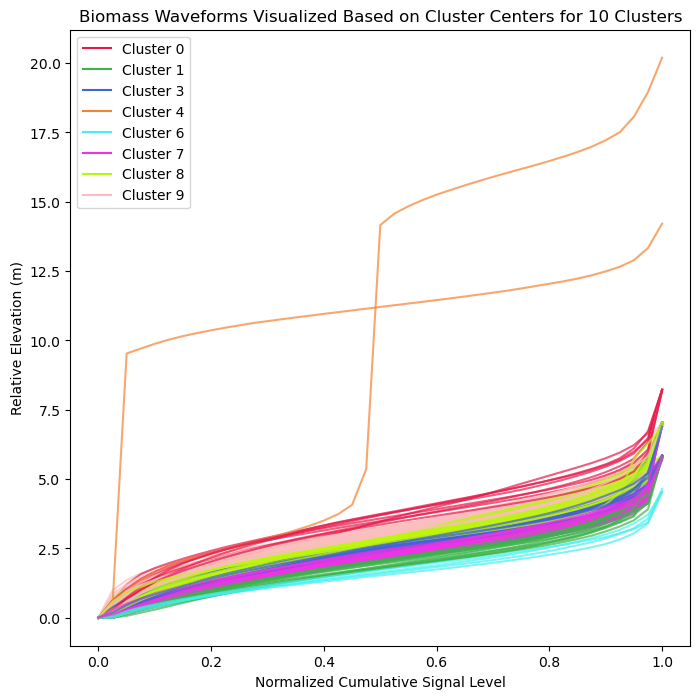

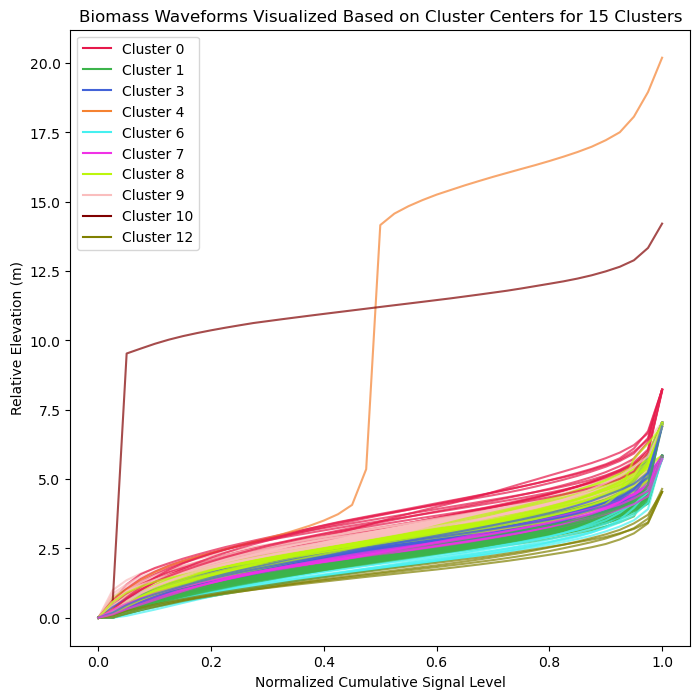

Total processing time: 158.99080300331116


In [59]:
# K_means_cluster execution and setup with all waveforms
# Cluster 500,000 waveforms with associated biomass values within these clusters
# Input assumption: Input excel file with waveform data is sorted by filename

waveform_start_L022 = 3580000
waveform_end_L022 = 3680000

waveform_start_L018 = 4900000
waveform_end_L018 = 5000000
waveform_start_L018_2 = 7080000
waveform_end_L018_2 = 7180000

waveform_start_L019 = 4700000
waveform_end_L019 = 4800000
waveform_start_L019_2 = 8310000
waveform_end_L019_2 = 8410000

waveform_file_L022 = '/Users/felixyu/Documents/Remote-Sensing/Neon-Pls-Wvs-Las/data/NEON_D01_HARV_DP1_L022-1_2019082013_1.pls'.split('.')
waveform_file_L019 = '/Users/felixyu/Documents/Remote-Sensing/Neon-Pls-Wvs-Las/data/NEON_D01_HARV_DP1_L019-1_2019082013_1.pls'.split('.')
waveform_file_L018 = '/Users/felixyu/Documents/Remote-Sensing/Neon-Pls-Wvs-Las/data/NEON_D01_HARV_DP1_L018-1_2019082013_1.pls'.split('.')

pls_file_L022 = waveform_file_L022[0] + '.pls'
wvs_file_L022 = waveform_file_L022[0] + '.wvs'
pls_file_L019 = waveform_file_L019[0] + '.pls'
wvs_file_L019 = waveform_file_L019[0] + '.wvs'
pls_file_L018 = waveform_file_L018[0] + '.pls'
wvs_file_L018 = waveform_file_L018[0] + '.wvs'

k_list = [10, 15]

biomass_waveforms_df = pd.read_csv("/Users/felixyu/Documents/Remote-Sensing/Neon-Pls-Wvs-Las/data/biomass_waveform_data_main.csv")
shot_numbers_with_biomass = biomass_waveforms_df["Pulsenumber"].to_numpy()
associated_file_names = biomass_waveforms_df["FileName"].to_numpy()

waveforms_with_biomass_interpolated = []
interpolated_waveforms = []

start = time.time()

cumulative_return_curves_L022 = get_cumulative_return_curves([waveform_start_L022], [waveform_end_L022], pls_file_L022, wvs_file_L022)
cumulative_return_curves_L018 = get_cumulative_return_curves([waveform_start_L018, waveform_start_L018_2], [waveform_end_L018, waveform_end_L018_2], pls_file_L018, wvs_file_L018)
cumulative_return_curves_L019 = get_cumulative_return_curves([waveform_start_L019, waveform_start_L019_2], [waveform_end_L019, waveform_end_L019_2], pls_file_L019, wvs_file_L019)

aggregated_cumulative_return_curves = cumulative_return_curves_L022 + cumulative_return_curves_L018 + cumulative_return_curves_L019

for waveform in aggregated_cumulative_return_curves:
    interpolated_wf_one, outlier = interpolate_waveform_values(waveform, False)

    if not outlier:
        interpolated_waveforms.append(interpolated_wf_one)
interpolated_waveforms = np.array(interpolated_waveforms)

# Get interpolated waveforms of only biomass data
waveforms_intensity_data = np.round(np.arange(0.0, 1.01, 0.025), 3)
waveforms_with_biomass = biomass_waveforms_df.iloc[:, 10:]
elevations_with_biomass_aggregated = (waveforms_with_biomass.apply(lambda row: np.array(row), axis=1)).to_numpy()

# Add intensity data with each elevation array
for elevation_arr in elevations_with_biomass_aggregated:
    waveform_with_biomass_interpolated = np.stack((waveforms_intensity_data, elevation_arr), axis=1).ravel()
    waveforms_with_biomass_interpolated.append(waveform_with_biomass_interpolated)

k_means_classifiers = train_k_means_cluster_cumulative_returns(interpolated_waveforms, k_list, True)
cluster_centers, cluster_assignments = test_k_means_cluster_cumulative_returns(k_means_classifiers, waveforms_with_biomass_interpolated, k_list, True, True)

# Plot results 
# Plot cluster centers vs full raw data for each k value
count = 0
for i, cluster_group in enumerate(cluster_centers):
    plt.figure(figsize=(8,8))
    
    for waveform in interpolated_waveforms:
        plt.plot(waveform[0::2], waveform[1::2], color='lightgray', alpha=0.7)
        count += 1
        if count > 5000:
            count = 0
            break

    for cluster in cluster_group:
        clustered_signal_levels = cluster[0::2]
        clustered_elevation = cluster[1::2]
        plt.plot(clustered_signal_levels, clustered_elevation, color='green')
    
    plt.title(f"Interpolated Waveforms vs. Clustered Center Waveforms for {k_list[i]} Clusters")
    plt.xlabel("Normalized Cumulative Signal Level")
    plt.ylabel("Relative Elevation (m)")
    waveform_legend = mlines.Line2D([], [], color='lightgray', alpha=0.7, label='Waveforms')
    cluster_legend = mlines.Line2D([], [], color='green', label='Clusters')
    plt.legend(handles=[waveform_legend, cluster_legend])
    plt.show()

# Plot cluster centers vs test data for each k value, highlighted by which cluster they belong to 
for i, cluster_assignment in enumerate(cluster_assignments):
    unique_clusters = np.unique(cluster_assignment)
    # Create a colormap with as many colors as there are clusters.
    colors = [
        '#e6194b',  # Vivid Red
        '#3cb44b',  # Kelly Green
        '#ffe119',  # Bright Yellow
        '#4363d8',  # Royal Blue
        '#f58231',  # Orange
        '#911eb4',  # Purple
        '#46f0f0',  # Cyan/Aqua
        '#f032e6',  # Magenta
        '#bcf60c',  # Lime Green
        '#fabebe',  # Light Pink
        '#800000',  # Maroon
        '#008080',  # Teal
        '#808000',  # Olive
        '#9A6324',  # Brown
        '#000075',  # Navy
    ]
    
    plt.figure(figsize=(8,8))
    # Plot each waveform with its corresponding cluster color.
    for waveform, cluster in zip(waveforms_with_biomass_interpolated, cluster_assignment):
        plt.plot(waveform[0::2], waveform[1::2], color=colors[cluster], alpha=0.7)
    
    # Create legend handles for each cluster color.
    cluster_handles = []
    for cluster in unique_clusters:
        handle = mlines.Line2D([], [], color=colors[cluster], label=f'Cluster {cluster}')
        cluster_handles.append(handle)
    
    plt.title(f"Biomass Waveforms Visualized Based on Cluster Centers for {k_list[i]} Clusters")
    plt.xlabel("Normalized Cumulative Signal Level")
    plt.ylabel("Relative Elevation (m)")
    plt.legend(handles=cluster_handles)
    plt.show()

# Save cluster assignments
columns = ['FileName', 'Pulsenumber', 'Cluster']

cluster_assignments_df_10 = pd.DataFrame(columns=columns)
cluster_assignments_df_10 = cluster_assignments_df_10.astype({'FileName': 'string','Pulsenumber': 'int64','Cluster': 'int32'})
cluster_assignments_df_15 = cluster_assignments_df_10.copy()

for i, pulsenum in enumerate(shot_numbers_with_biomass):
    new_cluster_row = {
        'FileName': associated_file_names[i],
        'Pulsenumber': pulsenum,
        'Cluster': cluster_assignments[0][i]
    }
    cluster_assignments_df_10.loc[len(cluster_assignments_df_10)] = new_cluster_row

for i, pulsenum in enumerate(shot_numbers_with_biomass):
    new_cluster_row = {
        'FileName': associated_file_names[i],
        'Pulsenumber': pulsenum,
        'Cluster': cluster_assignments[1][i]
    }
    cluster_assignments_df_15.loc[len(cluster_assignments_df_15)] = new_cluster_row
    
cluster_assignments_df_10.to_csv("waveform_biomass_cluster_assignments_k_10.csv", index=False)
cluster_assignments_df_15.to_csv("waveform_biomass_cluster_assignments_k_15.csv", index=False)

end = time.time()
print(f"Total processing time: {end-start}")

182


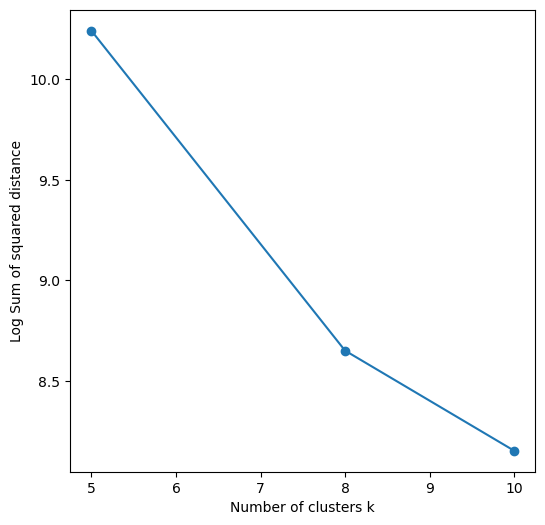

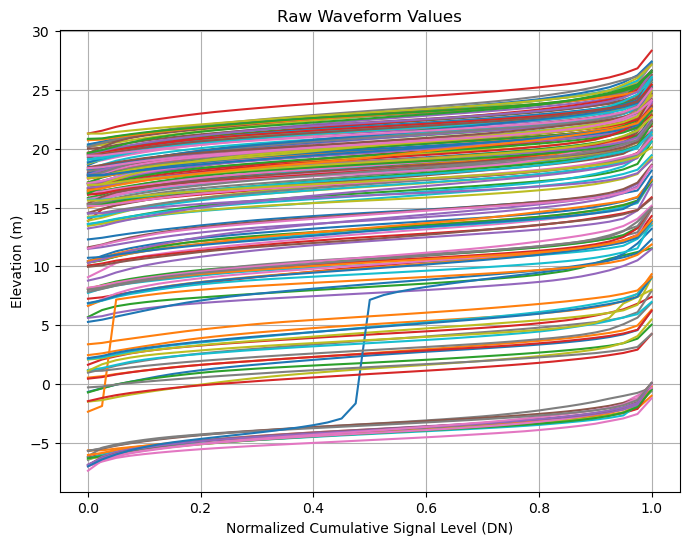

K: 5 Silhouette Score: 0.5246527335710692, Davies Bouldin Score: 0.5425162479125779
K: 8 Silhouette Score: 0.5779369910442247, Davies Bouldin Score: 0.5526953551059985
K: 10 Silhouette Score: 0.5417897820682325, Davies Bouldin Score: 0.45527538321333605


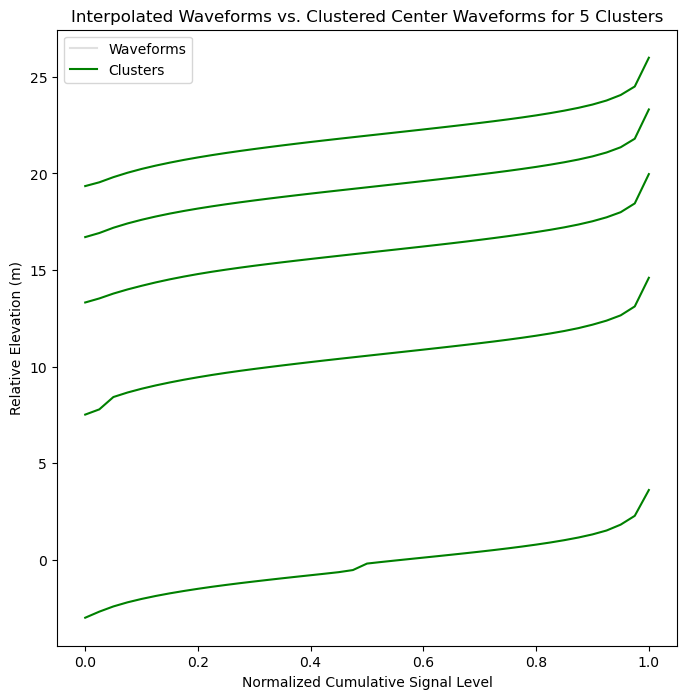

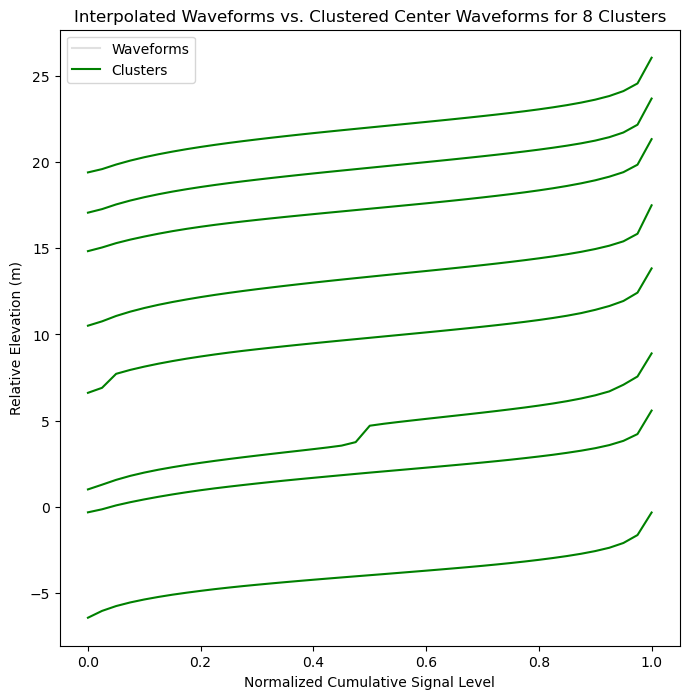

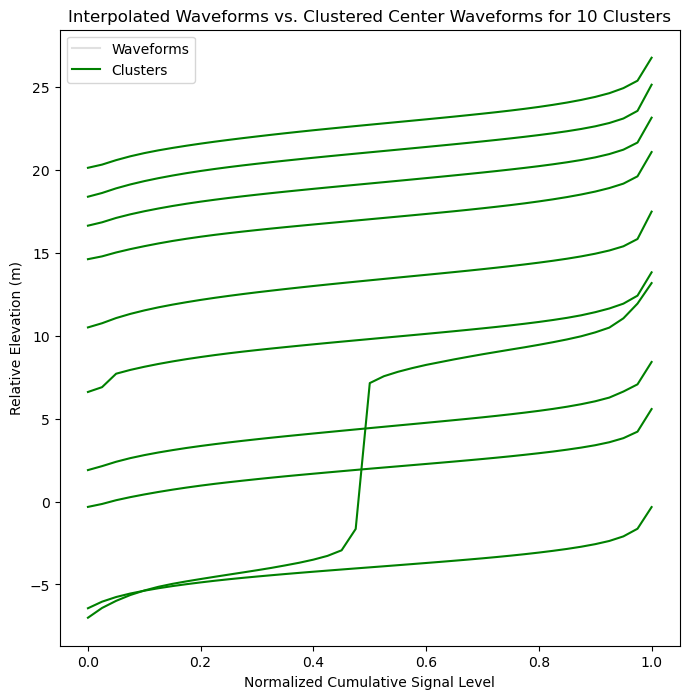

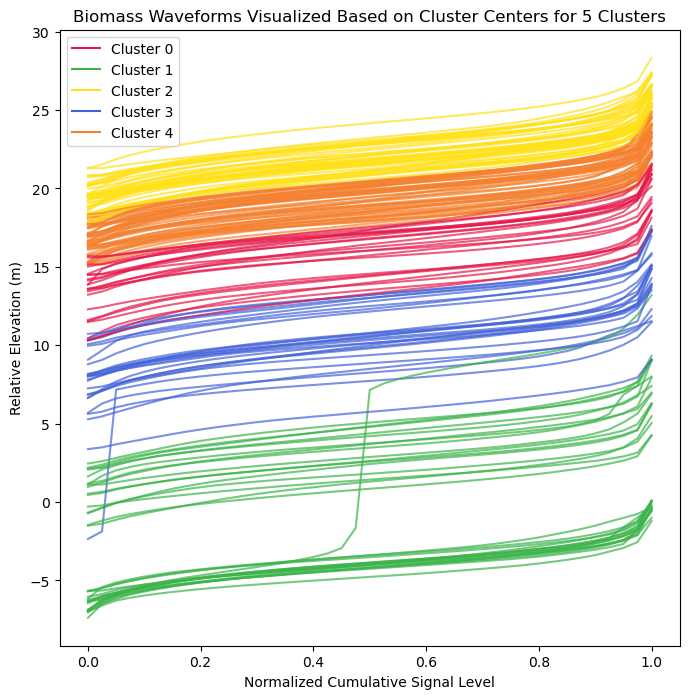

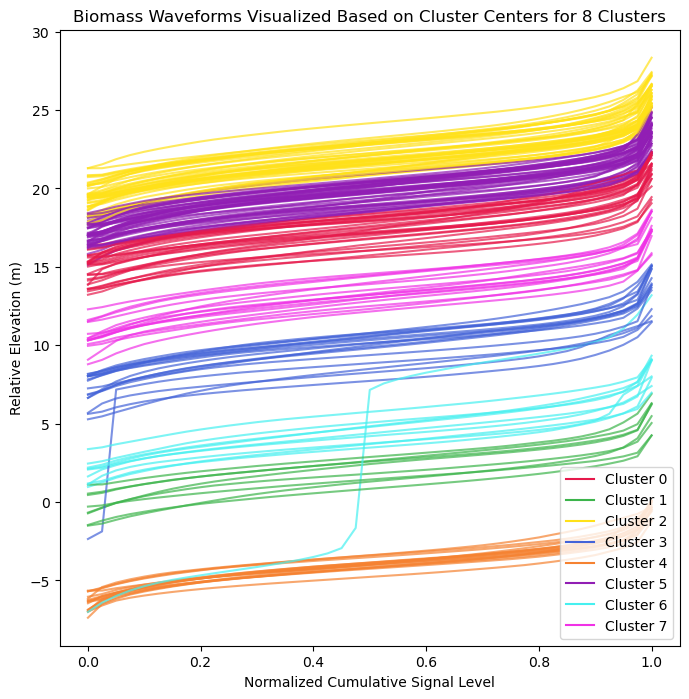

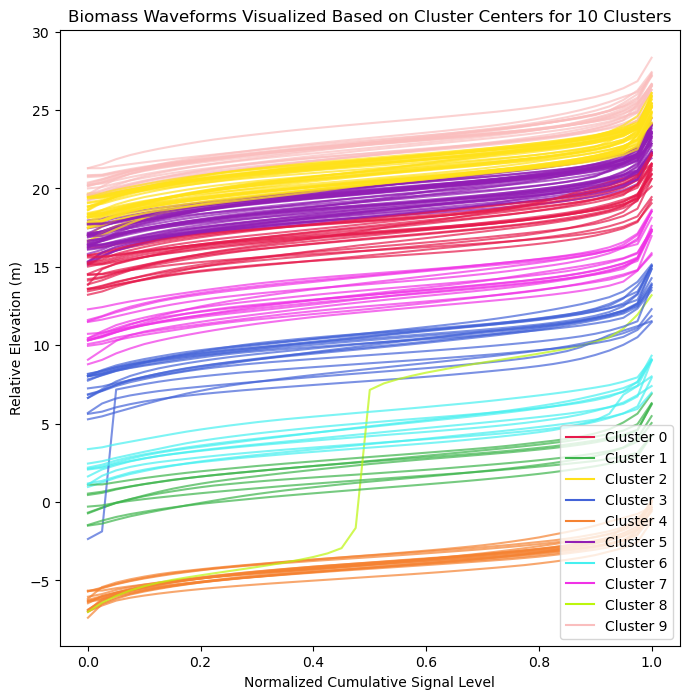

Total processing time: 1.3514060974121094


In [36]:
# K_means_cluster execution and setup with associated biomass values only
start = time.time()
biomass_waveforms_df = pd.read_csv('/Users/felixyu/Documents/Remote-Sensing/Neon-Pls-Wvs-Las/data/biomass_waveform_data_main.csv')

k_list = [5, 8, 10]
waveforms_with_biomass_interpolated = []

pulsenumbers = biomass_waveforms_df["Pulsenumber"].to_numpy()
canopy_top_values = biomass_waveforms_df["CanopyTop"].to_numpy()
biomass_values = biomass_waveforms_df["Biomass"].to_numpy()
canopy_bottom_values = biomass_waveforms_df["CanopyBottom"].to_numpy()
surface_elevation_values = biomass_waveforms_df["SurfaceElevation"].to_numpy()
waveform_elevation_vals = biomass_waveforms_df.iloc[:, 10:].to_numpy()
waveform_elevation_RH975 = waveform_elevation_vals[:, [-2]]

print(len(pulsenumbers))

# Change 0 value to height of the canopy
height_to_bottom_canopy = canopy_bottom_values - surface_elevation_values
waveform_canopy_RH975 = height_to_bottom_canopy + waveform_elevation_RH975.flatten()

# Filter out waveforms with negative canopy heights and biomass values below 500 with a canopy height bigger than 20
# non_neg_biomass_ch_mask = ((waveform_canopy_RH975 < 20.0) | (biomass_values > 500)) & (height_to_bottom_canopy >= 0)
# pulsenumbers_filtered = pulsenumbers[non_neg_biomass_ch_mask]
# print(len(pulsenumbers_filtered))
# height_to_bottom_canopy_filtered = height_to_bottom_canopy[non_neg_biomass_ch_mask]
# waveform_elevation_vals_filtered = waveform_elevation_vals[non_neg_biomass_ch_mask, :]
# waveform_elevation_RH975_filtered = waveform_elevation_RH975[non_neg_biomass_ch_mask]
# height_to_bottom_canopy_filtered = height_to_bottom_canopy[non_neg_biomass_ch_mask]

# Add canopy height data to waveform elevation data
waveform_elevation_vals += height_to_bottom_canopy[:, np.newaxis]

# Get interpolated waveforms of only biomass data
waveforms_intensity_data = np.round(np.arange(0.0, 1.01, 0.025), 3)

# Add intensity data with each elevation array such that it goes intensity, elevation, intensity2, elevation2...
for elevation_arr in waveform_elevation_vals:
    waveform_with_biomass_interpolated = np.stack((waveforms_intensity_data, elevation_arr), axis=1).ravel()
    waveforms_with_biomass_interpolated.append(waveform_with_biomass_interpolated)

k_means_classifiers = train_k_means_cluster_cumulative_returns(waveforms_with_biomass_interpolated, k_list, True)
cluster_centers, cluster_assignments = test_k_means_cluster_cumulative_returns(k_means_classifiers, waveforms_with_biomass_interpolated, k_list, True, True)

# Plot results 
# Plot cluster centers vs full raw data for each k value
count = 0
for i, cluster_group in enumerate(cluster_centers):
    plt.figure(figsize=(8,8))
    
    for waveform in interpolated_waveforms:
        plt.plot(waveform[0::2], waveform[1::2], color='lightgray', alpha=0.7)
        count += 1
        if count > 5000:
            count = 0
            break

    for cluster in cluster_group:
        clustered_signal_levels = cluster[0::2]
        clustered_elevation = cluster[1::2]
        plt.plot(clustered_signal_levels, clustered_elevation, color='green')
    
    plt.title(f"Interpolated Waveforms vs. Clustered Center Waveforms for {k_list[i]} Clusters")
    plt.xlabel("Normalized Cumulative Signal Level")
    plt.ylabel("Relative Elevation (m)")
    waveform_legend = mlines.Line2D([], [], color='lightgray', alpha=0.7, label='Waveforms')
    cluster_legend = mlines.Line2D([], [], color='green', label='Clusters')
    plt.legend(handles=[waveform_legend, cluster_legend])
    plt.show()

# Plot cluster centers vs test data for each k value, highlighted by which cluster they belong to 
for i, cluster_assignment in enumerate(cluster_assignments):
    unique_clusters = np.unique(cluster_assignment)
    # Create a colormap with as many colors as there are clusters.
    colors = [
        '#e6194b',  # Vivid Red
        '#3cb44b',  # Kelly Green
        '#ffe119',  # Bright Yellow
        '#4363d8',  # Royal Blue
        '#f58231',  # Orange
        '#911eb4',  # Purple
        '#46f0f0',  # Cyan/Aqua
        '#f032e6',  # Magenta
        '#bcf60c',  # Lime Green
        '#fabebe',  # Light Pink
        '#800000',  # Maroon
        '#008080',  # Teal
        '#808000',  # Olive
        '#9A6324',  # Brown
        '#000075',  # Navy
    ]
    
    plt.figure(figsize=(8,8))
    # Plot each waveform with its corresponding cluster color.
    for waveform, cluster in zip(waveforms_with_biomass_interpolated, cluster_assignment):
        plt.plot(waveform[0::2], waveform[1::2], color=colors[cluster], alpha=0.7)
    
    # Create legend handles for each cluster color.
    cluster_handles = []
    for cluster in unique_clusters:
        handle = mlines.Line2D([], [], color=colors[cluster], label=f'Cluster {cluster}')
        cluster_handles.append(handle)
    
    plt.title(f"Biomass Waveforms Visualized Based on Cluster Centers for {k_list[i]} Clusters")
    plt.xlabel("Normalized Cumulative Signal Level")
    plt.ylabel("Relative Elevation (m)")
    plt.legend(handles=cluster_handles)
    plt.show()

# Save cluster assignments
columns = ['FileName', 'Pulsenumber', 'Cluster']

cluster_assignments_df_10 = pd.DataFrame(columns=columns)
cluster_assignments_df_10 = cluster_assignments_df_10.astype({'FileName': 'string','Pulsenumber': 'int64','Cluster': 'int32'})
cluster_assignments_df_15 = cluster_assignments_df_10.copy()

for i, pulsenum in enumerate(shot_numbers_with_biomass):
    new_cluster_row = {
        'FileName': associated_file_names[i],
        'Pulsenumber': pulsenum,
        'Cluster': cluster_assignments[1][i]
    }
    cluster_assignments_df_10.loc[len(cluster_assignments_df_10)] = new_cluster_row

# for i, pulsenum in enumerate(shot_numbers_with_biomass):
#     new_cluster_row = {
#         'FileName': associated_file_names[i],
#         'Pulsenumber': pulsenum,
#         'Cluster': cluster_assignments[1][i]
#     }
#     cluster_assignments_df_15.loc[len(cluster_assignments_df_15)] = new_cluster_row
    
cluster_assignments_df_10.to_csv("waveform_biomass_cluster_assignments_k.csv", index=False)
# cluster_assignments_df_15.to_csv("waveform_biomass_cluster_assignments_k_15.csv", index=False)

end = time.time()
print(f"Total processing time: {end-start}")

In [35]:
start = time.time()
k = 4
processed_waveforms, cluster_centers = k_means_cluster_cumulative_returns(0, 100, [k], False, False, True)

# Plot clusters and raw data together
clustered_signal_level = cluster_centers[0][0::2]
clustered_elevation = cluster_centers[0][1::2]

plt.figure(figsize=(8, 8))
for waveform in processed_waveforms:
    plt.plot(waveform[0::2], waveform[1::2], color='lightgray', alpha=0.7)
for cluster in cluster_centers[0]:
    plt.plot(cluster[0::2], cluster[1::2], color='green')

waveform_legend = mlines.Line2D([], [], color='lightgray', alpha=0.7, label='Waveforms')
cluster_legend = mlines.Line2D([], [], color='green', label='Clusters')

plt.title("Interpolated Waveforms vs. Clustered Waveforms")
plt.xlabel("Normalized Cumulative Signal Level")
plt.ylabel("Relative Elevation (m)")
plt.legend(handles=[waveform_legend, cluster_legend])
plt.show()

end = time.time()
print(f"Processing time k-means {end - start}s")

NameError: name 'k_means_cluster_cumulative_returns' is not defined

Easting(x) min: -100.0, Easting(x) max: 732915.0519600005, Northing(y) min: -100.0, Northing(y) max: 4717999.827959995


NameError: name 'waveform_easting_firstreturn_array' is not defined

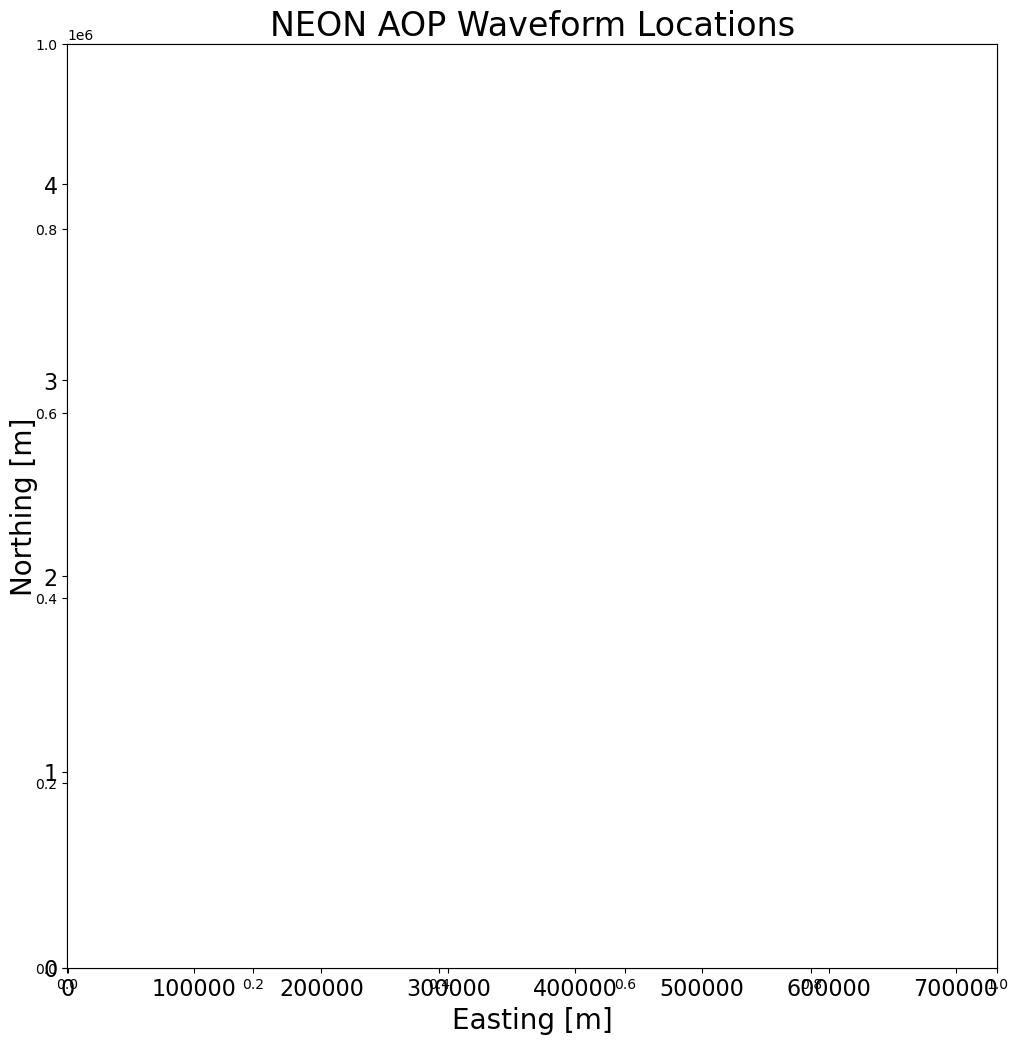

In [20]:
# Plot data coverage
start = time.time()
xmin = np.min(utmEasting_bin0_array) - 100.0
xmax = np.max(utmEasting_bin0_array) + 100.0
ymin = np.min(utmNorthing_bin0_array) - 100.0
ymax = np.max(utmNorthing_bin0_array) + 100.0
print(f"Easting(x) min: {xmin}, Easting(x) max: {xmax}, Northing(y) min: {ymin}, Northing(y) max: {ymax}")

plt.subplots(figsize=(12*1.0, 12*1.0))
ax = plt.axes()
ax.set_xlim((xmin,xmax))
ax.set_ylim((ymin,ymax))
ax.tick_params(axis='both',which='major',labelsize=16)
ax.set_title('NEON AOP Waveform Locations', size = 24)
ax.set_xlabel('Easting [m]', size = 20)
ax.set_ylabel('Northing [m]', size = 20)
ax.scatter(waveform_easting_firstreturn_array, waveform_northing_firstreturn_array, c = waveform_rgb_lut1[0:100], cmap = 'rainbow', s = 4, zorder = 2)

print(waveform_easting_firstreturn_array[0])
plt.show() 
end = time.time()
print(f"Processing time {end-start}s")


In [21]:
# Input: Laz file, easting and northing locations of waveform
# Output: Graph of points at those locations
def plot_point_cloud_data(laz_file, x_locations, y_locations):
    
    point_cloud=laspy.read(laz_file)
    point_cloud_xyz = np.round(point_cloud.xyz, decimals=2)
    
    # Retrieve boundaries of location data
    x_loc_min = np.min(x_locations)
    x_loc_max = np.max(x_locations)
    y_loc_min = np.min(y_locations)
    y_loc_max = np.max(y_locations)

    # Get mask from location
    mask = (point_cloud_xyz[:, 0] >= x_loc_min) & (point_cloud_xyz[:, 0] <= x_loc_max) & \
       (point_cloud_xyz[:, 1] >= y_loc_min) & (point_cloud_xyz[:, 1] <= y_loc_max)

    masked_indices = np.where(mask)[0]
    masked_point_cloud = point_cloud_xyz[mask]
    print(masked_point_cloud)
    
    # Plot data
    # Z is elevation
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(masked_point_cloud[:, 0], masked_point_cloud[:, 1], masked_point_cloud[:, 2], color='red', s=5)
    ax.set_xlabel("Easting")
    ax.set_ylabel("Northing")
    ax.set_zlabel("Elevation")
    ax.set_title("Waveform Point Cloud Visualization")
    plt.show()

[[7.32929100e+05 4.71749673e+06 3.53620000e+02]
 [7.32929730e+05 4.71749674e+06 3.53620000e+02]
 [7.32930400e+05 4.71749675e+06 3.53370000e+02]]


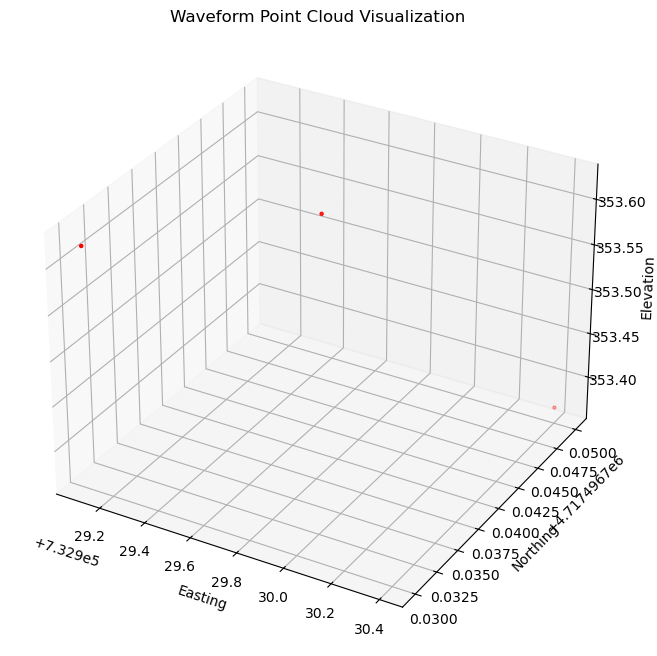

In [244]:
plot_point_cloud_data(point_cloud_file_laz, waveform_x_axis, waveform_y_axis)

In [240]:
def plot_full_point_cloud_data(laz_file):
    point_cloud=laspy.read(laz_file)
    point_cloud_xyz = point_cloud.xyz
    factor=100
    points_dec = point_cloud_xyz[::factor]
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points_dec[:,0],points_dec[:,1],points_dec[:,2],color='blue',s=4)
    plt.show()

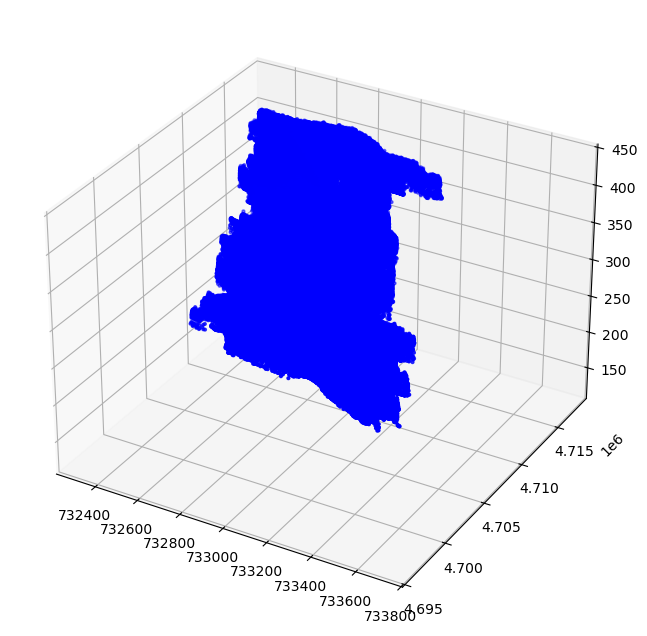

In [241]:
plot_full_point_cloud_data(point_cloud_file_laz)